In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
from ahrs.filters import Mahony

import importlib
importlib.reload(fetch_data)

start_date_str = '2023-05-30'
end_date_str = '2023-06-01'
organization_id = 'hamid'
can_k3y_id = '9ed5b50e'
imu_k3y_id = '78f8031e'

Get the CAN Server data

In [2]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)

Get the raw IMU data

In [17]:
raw_acc_df, raw_gyro_df = fetch_data.get_raw_data(imu_k3y_id, organization_id, start_date_str, end_date_str)
start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')
time_df = correct_drift.fetch_time_data(imu_k3y_id, organization_id, start_date, end_date)

Define Functions for Computing Orientation

In [21]:
k3y_g = 9.81
# SR = 26
SR = 170
S3_K3Y_VEH_ROT_MTX = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
# madgwick_params = {'gain': 0.05, 'imu_gain': 0.0001,
                #    'init_qua': [0,0,0,1]}
madgwick_params = {'gain': 0.05, 'imu_gain': 0.0001,
                   'init_qua': [0,0,0,1]}
butter_params = {'order': 4, 'Wn': 10.0}

def calculate_rot_matrix(ac_data, gy_data, sr=SR, filter_params=madgwick_params):
    # ac_data[:,0] = lowpass_filt(ac_data[:,0], sr=SR, wn=butter_params['Wn'])
    # ac_data[:,1] = lowpass_filt(ac_data[:,1], sr=SR, wn=butter_params['Wn'])
    # ac_data[:,2] = lowpass_filt(ac_data[:,2], sr=SR, wn=butter_params['Wn'])
    # gy_data[:,0] = lowpass_filt(gy_data[:,0], sr=SR, wn=butter_params['Wn'])
    # gy_data[:,1] = lowpass_filt(gy_data[:,1], sr=SR, wn=butter_params['Wn'])
    # gy_data[:,2] = lowpass_filt(gy_data[:,2], sr=SR, wn=butter_params['Wn'])
    madg_filter = Madgwick(acc=ac_data, gyr=gy_data, Dt=(1/sr), gain=filter_params['gain'],
                        q0=filter_params['init_qua'], gain_imu=filter_params['imu_gain'])
    # madg_filter = Mahony(acc=ac_data, gyr=gy_data, Dt=(1/sr),
    #                     q0=filter_params['init_qua'], k_P=0.001)
    quaternions = madg_filter.Q
    madgwick_params['init_qua'] = quaternions[-1,:]
    # converting quaternion from scalar first (AHRS library) to scalar last(SciPy)
    quaternions_scipy = np.roll(quaternions, shift=3, axis=1)
    rot_mtxs = R.from_quat(quaternions_scipy).as_matrix()

    return rot_mtxs

def gravity_compensate(ac_batch, gy_batch, g=k3y_g):
    rotation_mtxs = calculate_rot_matrix(ac_data=ac_batch, gy_data=gy_batch)
    # Rotation matrix is orthogonal, last colum = last row of the inverse
    gravity_components = g * rotation_mtxs[:,-1,:]
    ac_g_compensated = ac_batch - gravity_components

    return ac_g_compensated

def imu_k3y_to_vehicle(ac_batch_np, gy_batch_np):
    g_removed_ac_np = gravity_compensate(ac_batch=ac_batch_np[:, 1:], gy_batch=gy_batch_np[:, 1:], g=k3y_g)
    vehicle_ac = np.matmul(S3_K3Y_VEH_ROT_MTX, g_removed_ac_np.T)
    vehicle_ac_np = np.column_stack((ac_batch_np[:,0], vehicle_ac.T))

    return vehicle_ac_np

def lowpass_filt(data, sr=SR, wn=butter_params['Wn'],
                order=butter_params['order']):
    b, a = signal.butter(N=order, Wn=wn, analog=False, fs=sr)
    filt_data = signal.filtfilt(b, a, data)
    return filt_data

Filter the Data for Only Driving States

In [5]:
raw_acc_df = correct_drift.shift_time(raw_acc_df, time_df)
raw_gyro_df = correct_drift.shift_time(raw_gyro_df, time_df)

buffer = 5
ac_dr_df_list = []
for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    # get just the data within the driving state
    ac_dr_motion = raw_acc_df[(raw_acc_df['correct_timestamp'] >= dr_start_time - buffer) 
                        & (raw_acc_df['correct_timestamp'] <= dr_end_time)]
    gy_dr_motion = raw_gyro_df[(raw_gyro_df['correct_timestamp'] >= dr_start_time - buffer) 
                        & (raw_gyro_df['correct_timestamp'] <= dr_end_time)]
    if(len(ac_dr_motion) != 0 and len(gy_dr_motion) != 0):
        # gravity compensate batch
        merged_data = pd.merge(ac_dr_motion, gy_dr_motion, on='correct_timestamp', how='inner')
        raw_acc_np = merged_data[['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
        raw_gyro_np = merged_data[['correct_timestamp', 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)']].to_numpy()
        corrected_acc_np = imu_k3y_to_vehicle(raw_acc_np, raw_gyro_np)
        corrected_acc_df = pd.DataFrame(corrected_acc_np, columns=['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])
        ac_dr_df_list.append(corrected_acc_df)

raw_df = pd.concat(ac_dr_df_list, ignore_index=True)
# print(raw_df)

In [22]:
# cutoff_time = 1685550631.3832176
# raw_acc_df = raw_acc_df[raw_acc_df['timestamp(epoch in sec)'] < cutoff_time]
# raw_gyro_df = raw_gyro_df[raw_gyro_df['timestamp(epoch in sec)'] < cutoff_time]

merged_data = pd.merge(raw_acc_df, raw_gyro_df, on='timestamp(epoch in sec)', how='inner')
raw_acc_np = merged_data[['timestamp(epoch in sec)', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
raw_gyro_np = raw_gyro_df.to_numpy()

In [23]:
corrected_acc_np = imu_k3y_to_vehicle(raw_acc_np, raw_gyro_np)
corrected_acc_df = pd.DataFrame(corrected_acc_np, columns=['timestamp(epoch in sec)', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])
raw_df = correct_drift.shift_time(corrected_acc_df, time_df)

1


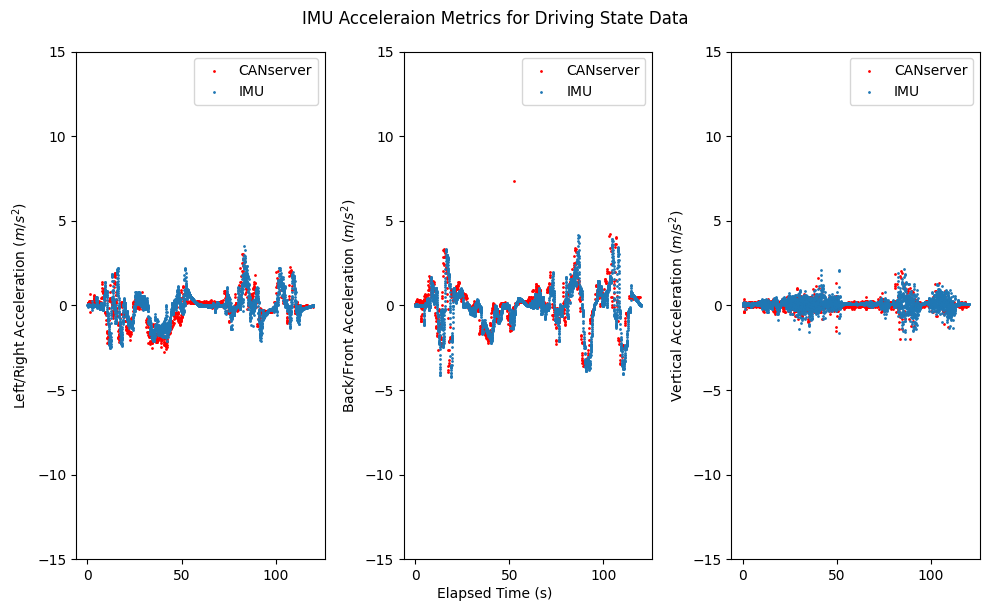

2


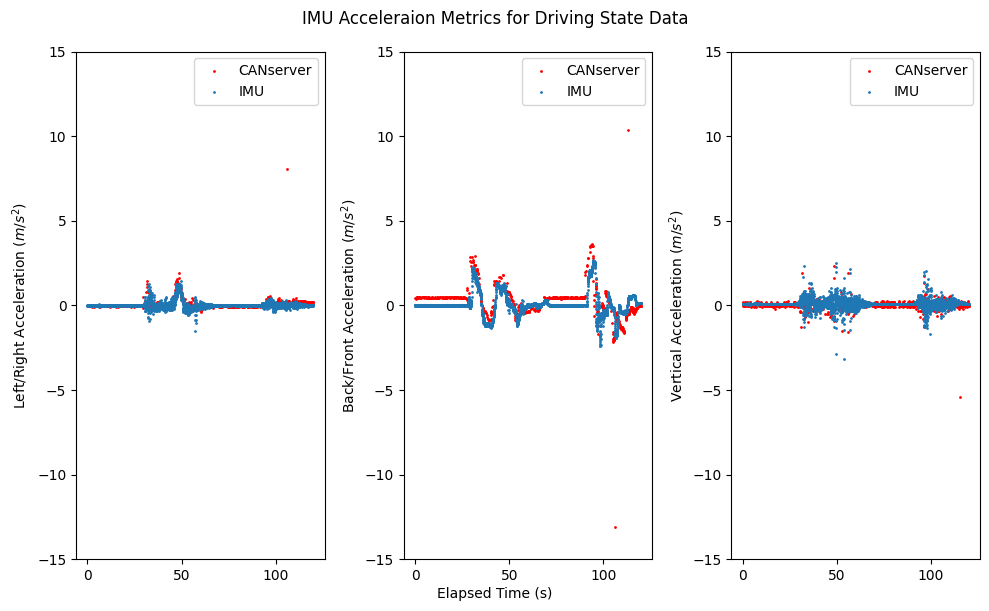

3


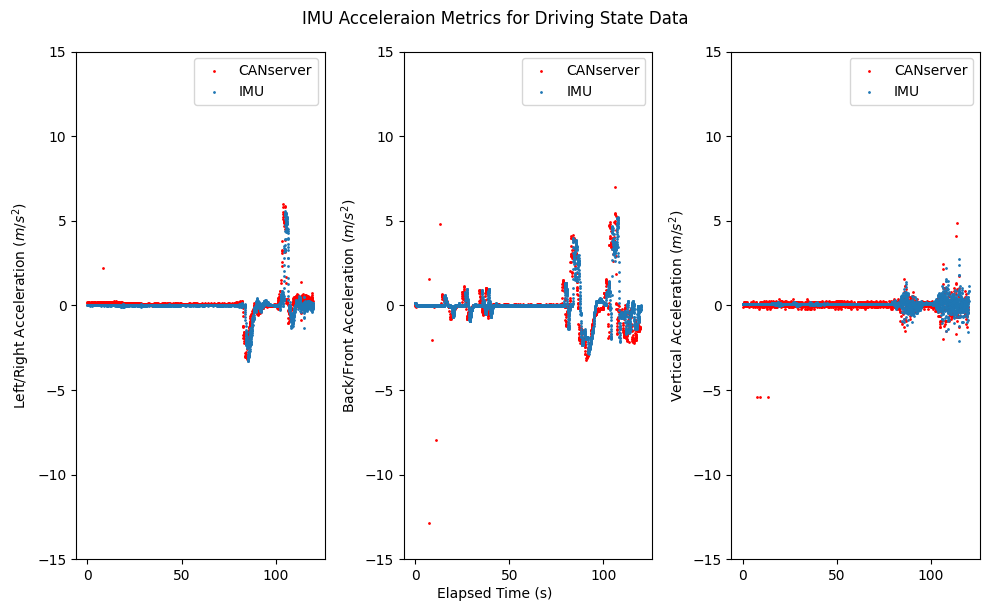

4


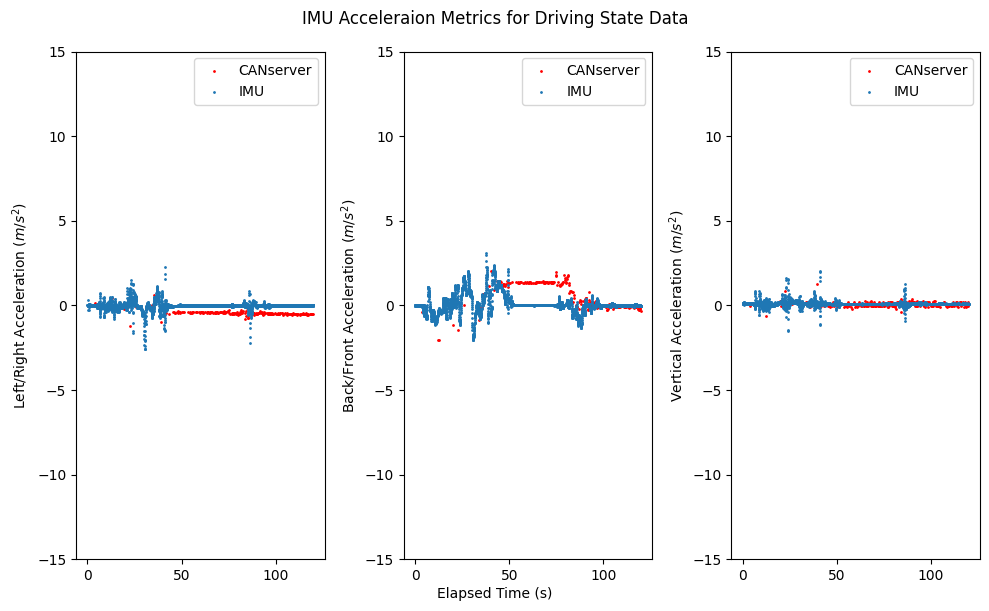

5


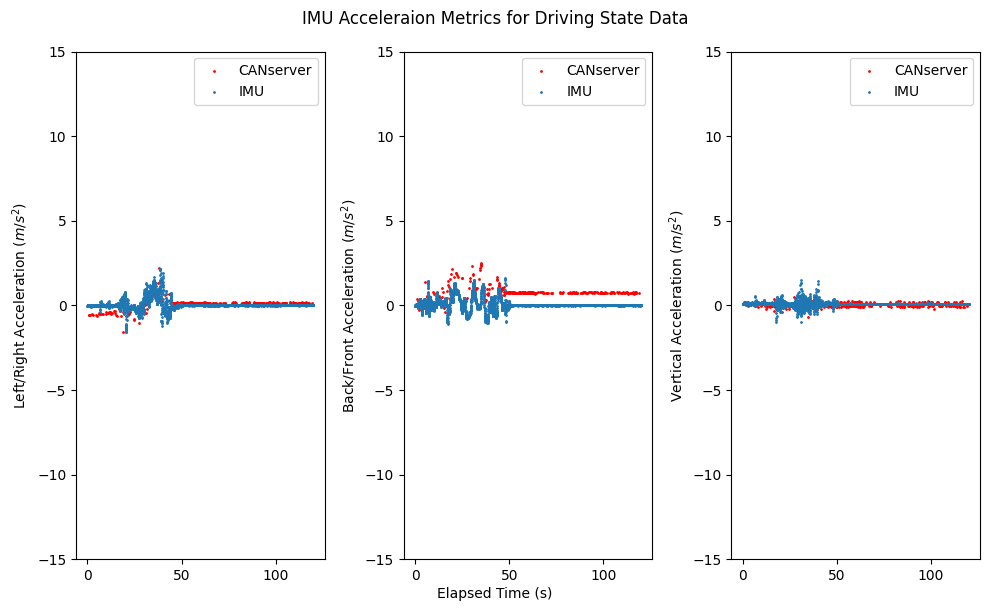

6


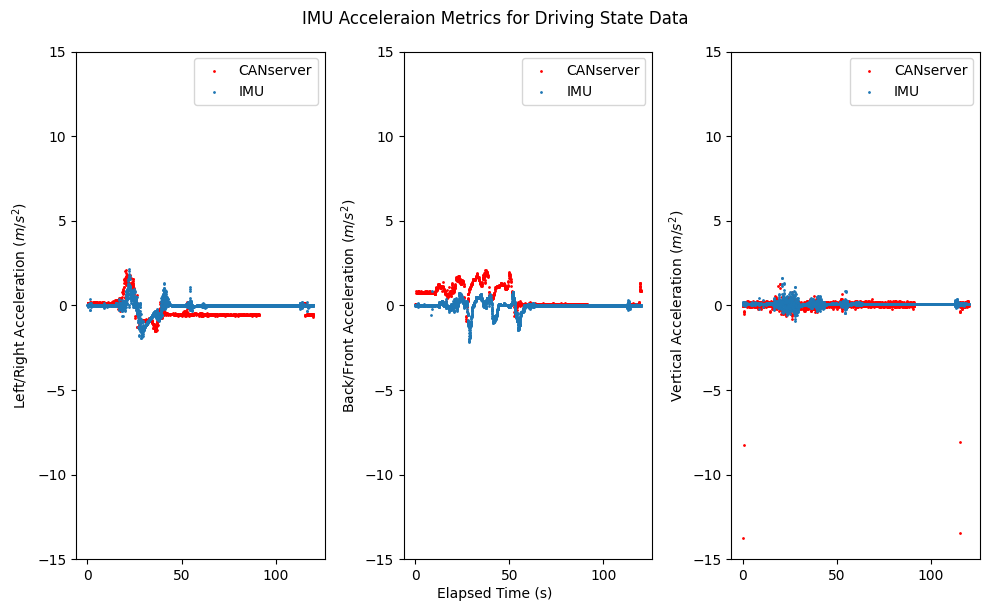

7


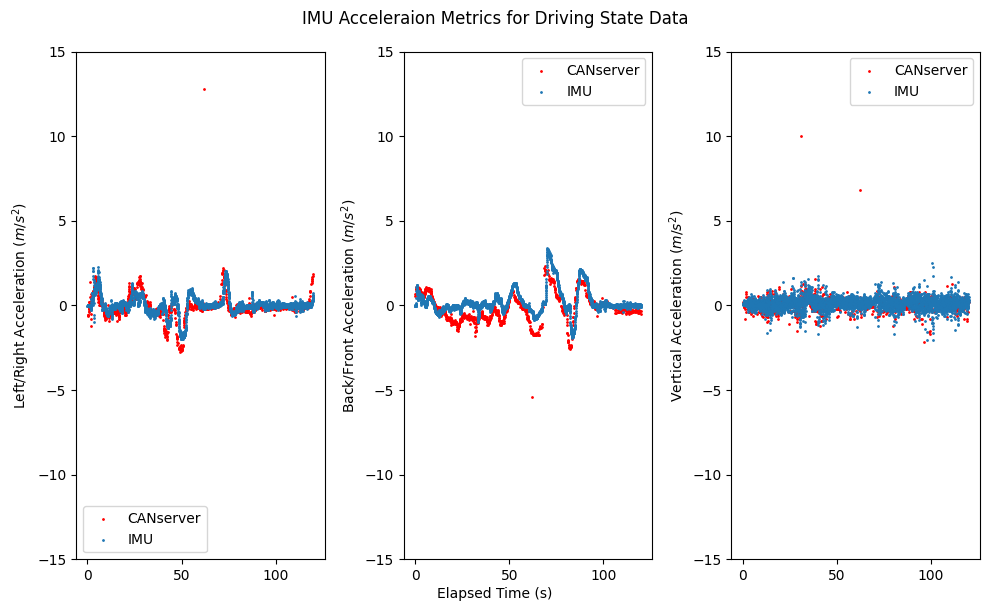

8


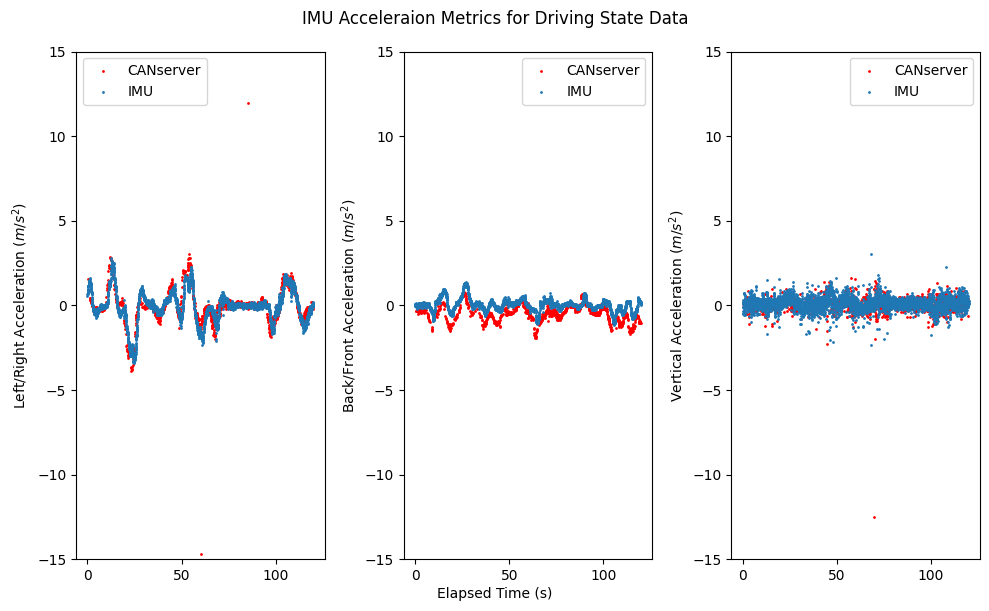

9


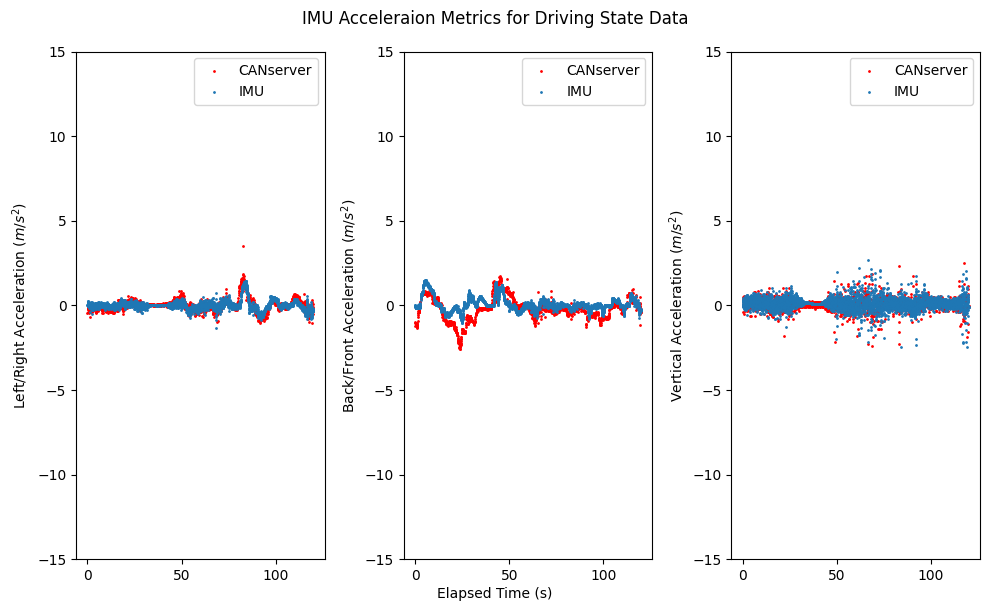

10


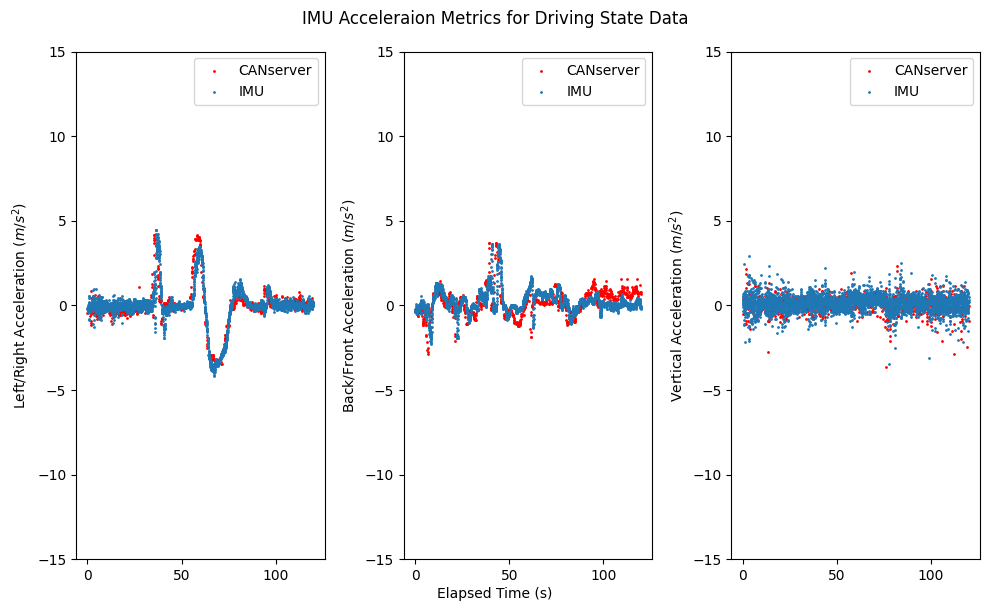

11


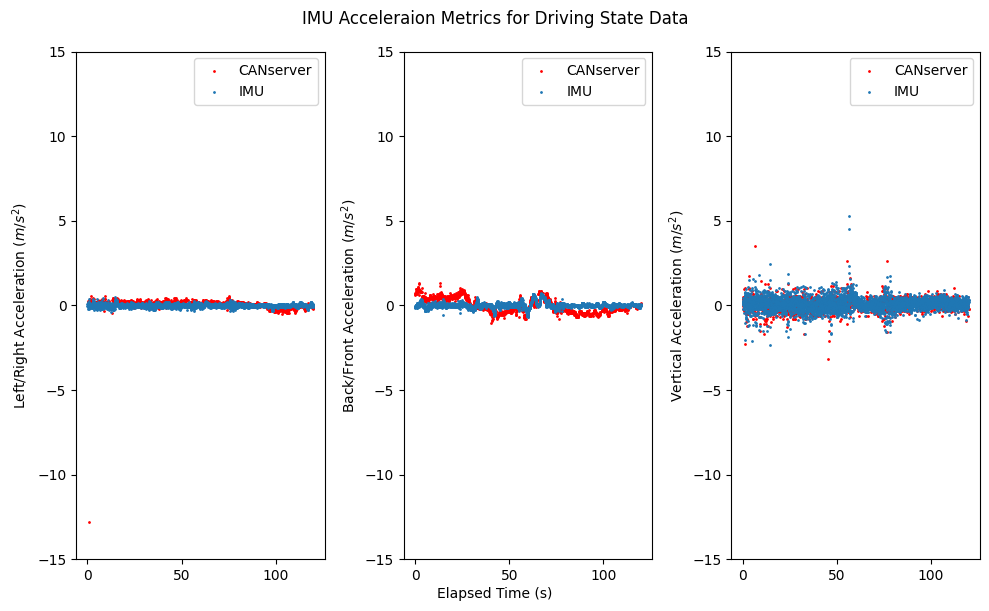

12


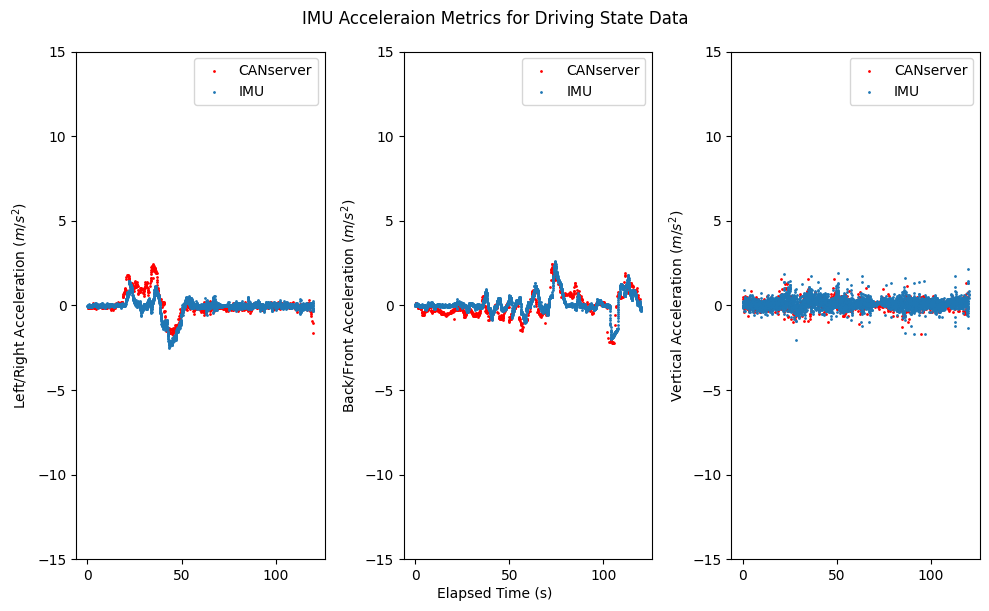

13


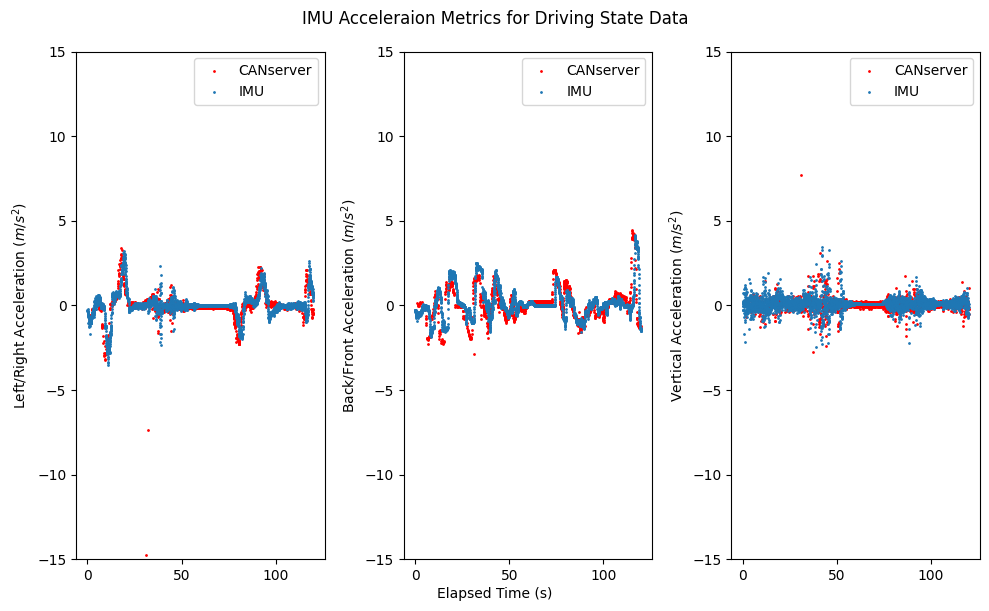

14


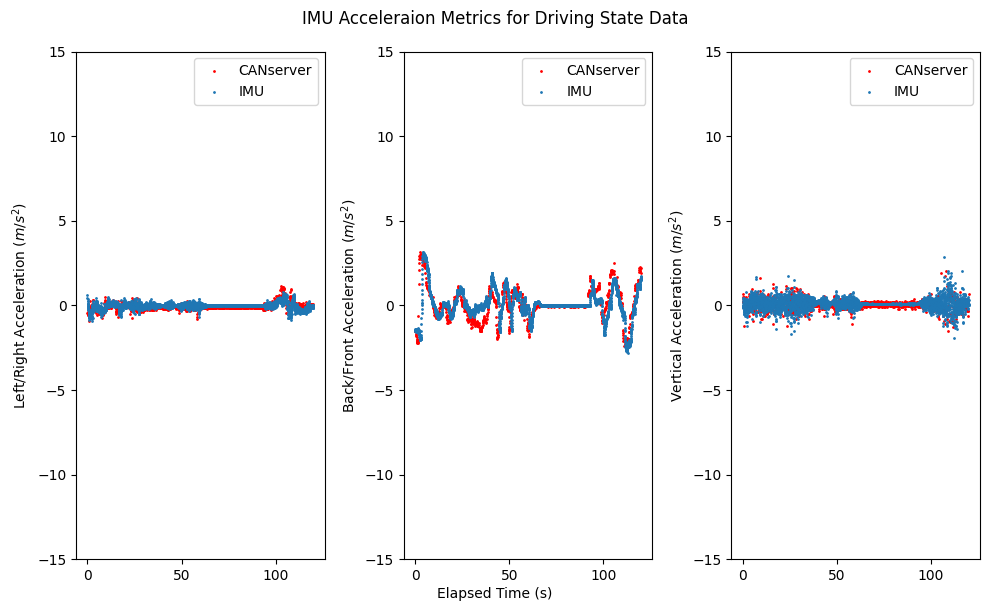

15


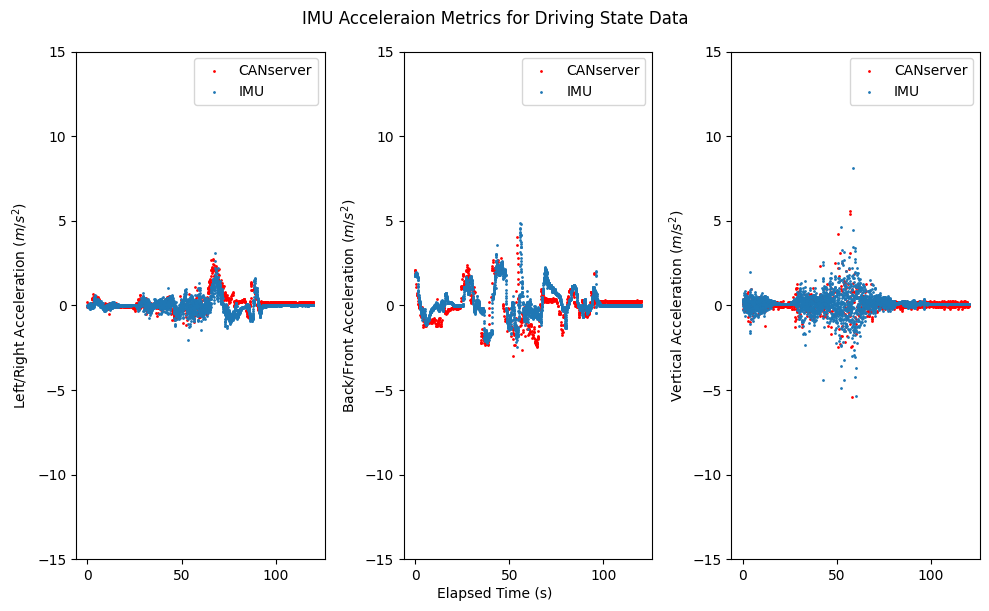

17


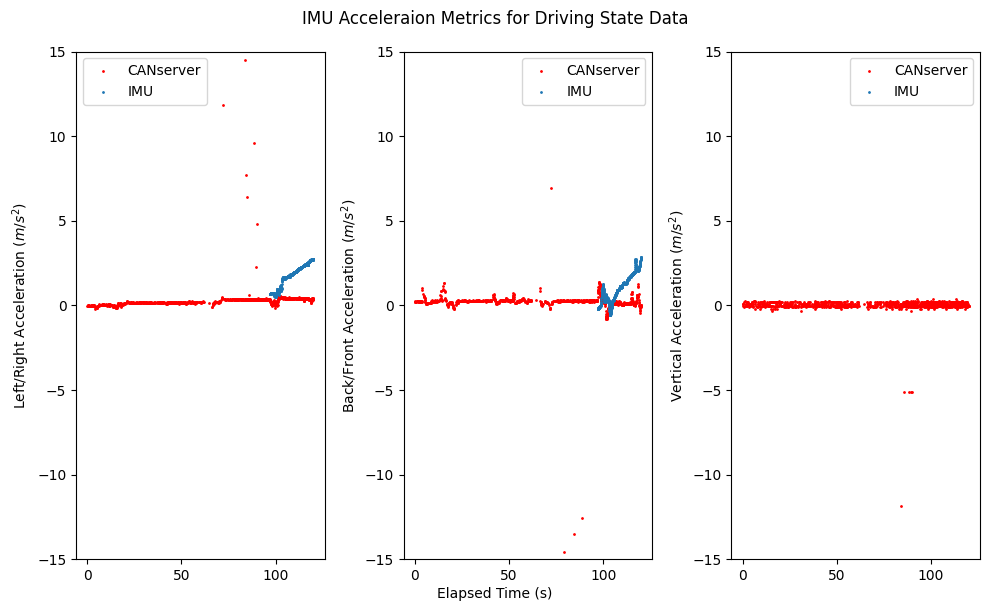

18


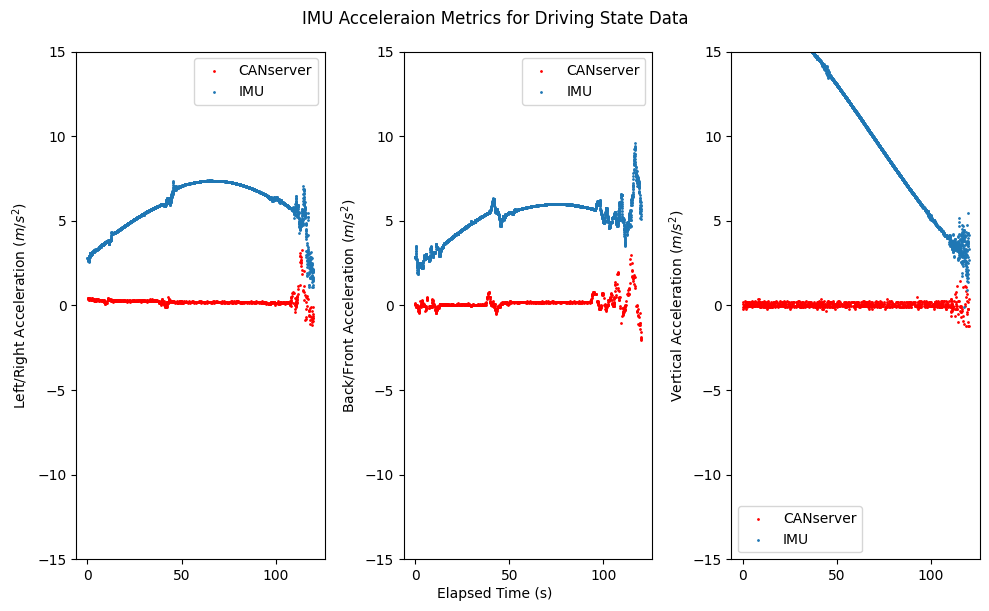

19


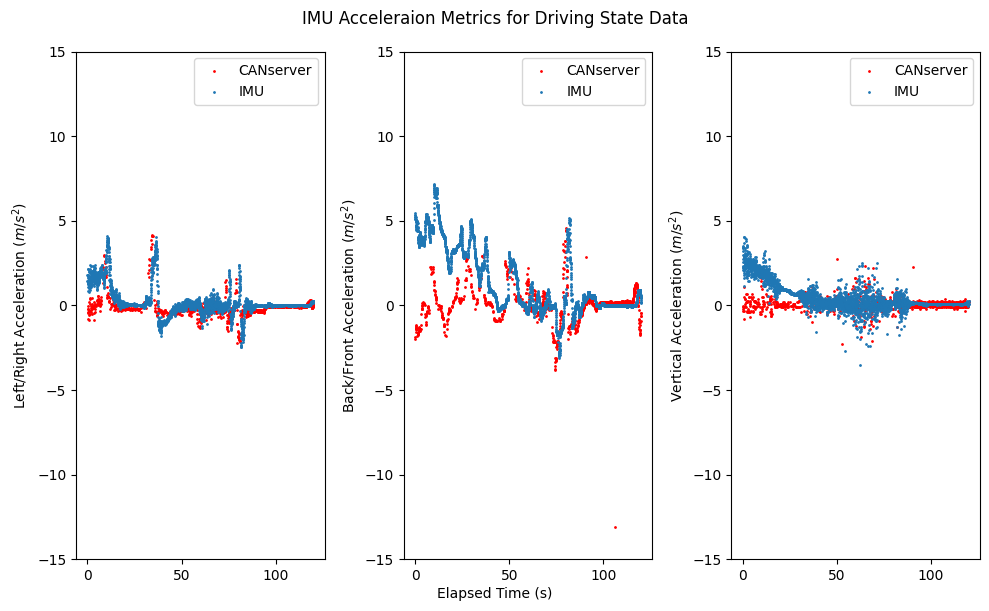

In [28]:
# plot driving state data in intervals of 120 seconds

window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = raw_df[(raw_df['correct_timestamp'] >= dr_start_time) 
                        & (raw_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and ((count == 8) or (count == 6))):
        if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
            print(count)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            lr_mean = dr_motion['lr_acc(m/s^2)'].mean()
            bf_mean = dr_motion['bf_acc(m/s^2)'].mean()
            vert_mean = dr_motion['vert_acc(m/s^2)'].mean()
            lr_can_mean = can_motion['lr_acc'].mean()
            bf_can_mean = can_motion['bf_acc'].mean()
            vert_can_mean = can_motion['vert_acc'].mean()

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()

CAN time is 1685492228.578194
IMU raw time is 1685492192.0348103
Delta is 36.54338359832764


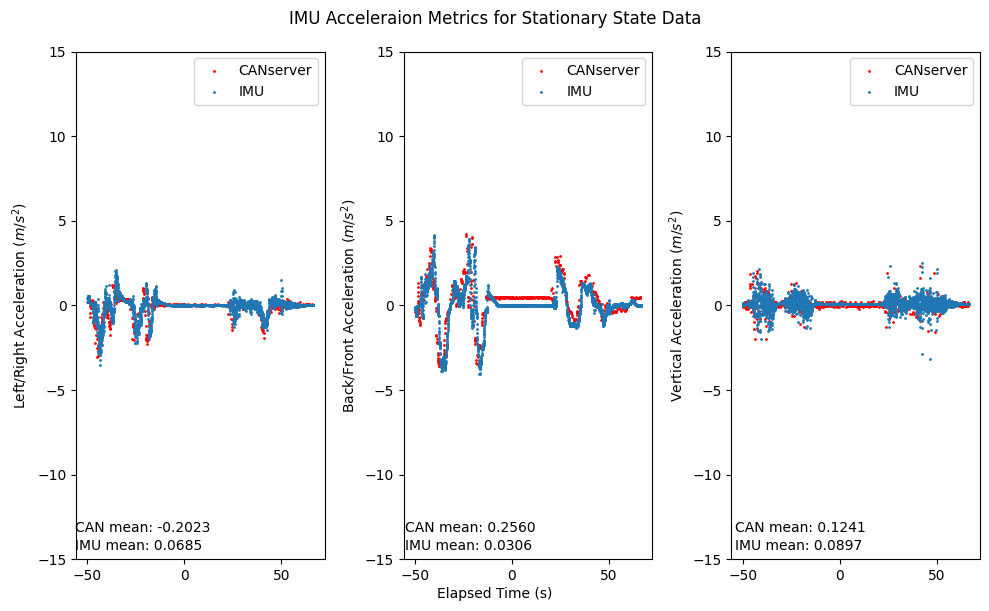

CAN time is 1685492345.709463
IMU raw time is 1685492309.114784
Delta is 36.59467887878418


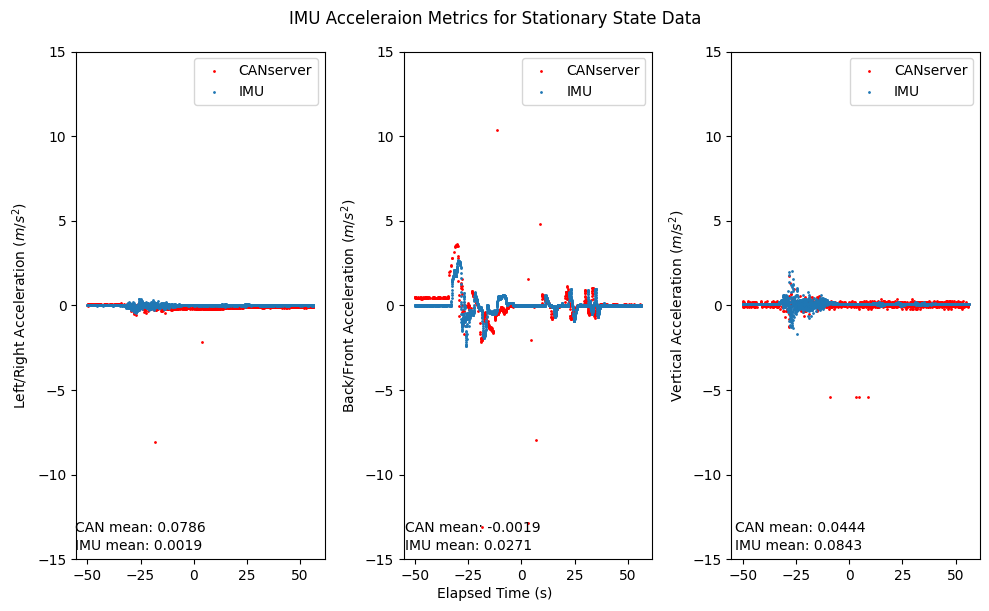

CAN time is 1685492388.031017
IMU raw time is 1685492351.1597104
Delta is 36.87130665779114


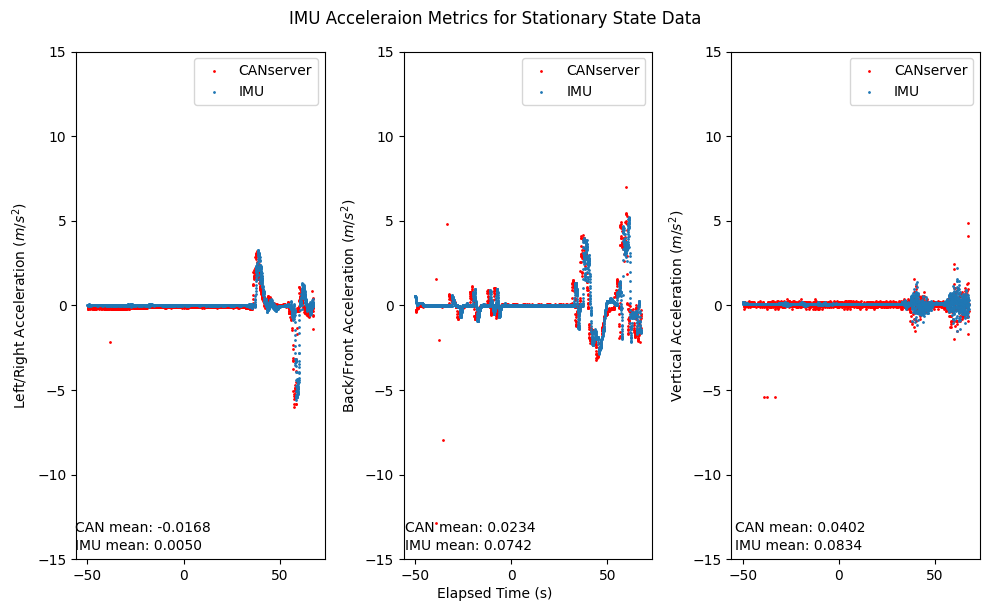

CAN time is 1685544310.067304
IMU raw time is 1685544300.1097183
Delta is 9.957585573196411


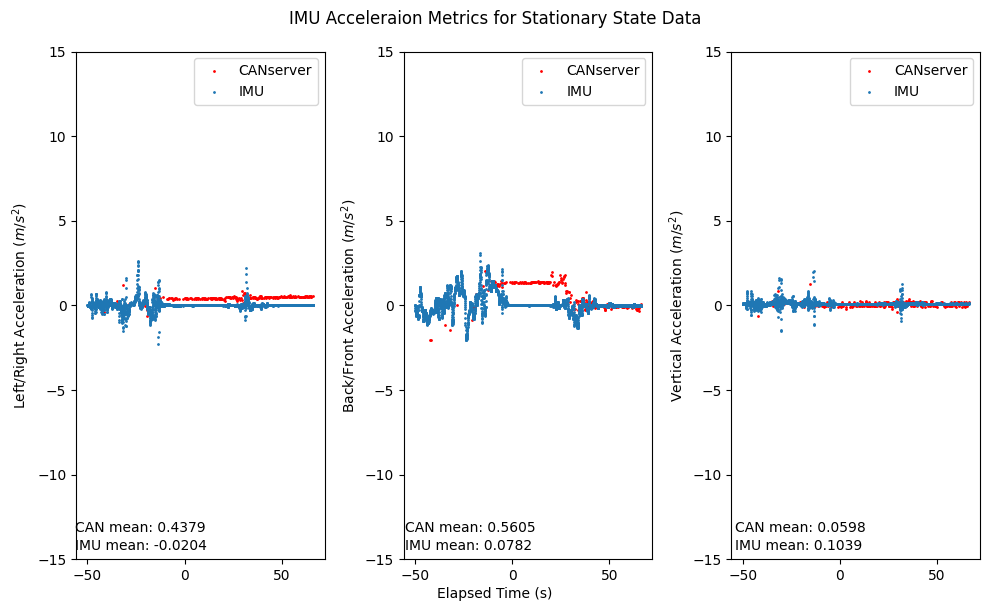

CAN time is 1685551021.684784
IMU raw time is 1685551009.654397
Delta is 12.030386924743652


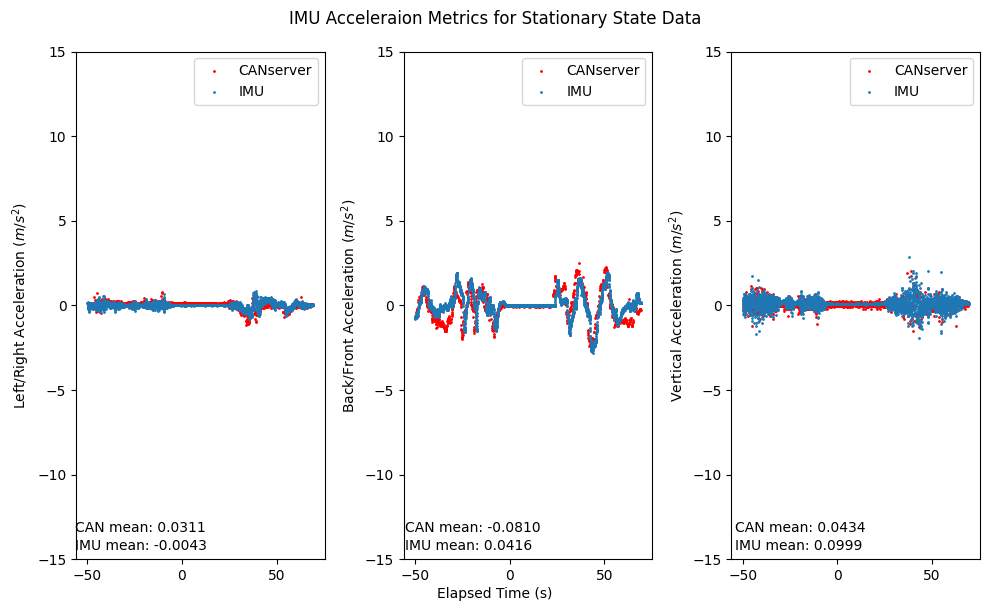

CAN time is 1685551172.110459
IMU raw time is 1685551159.7577803
Delta is 12.352678775787354


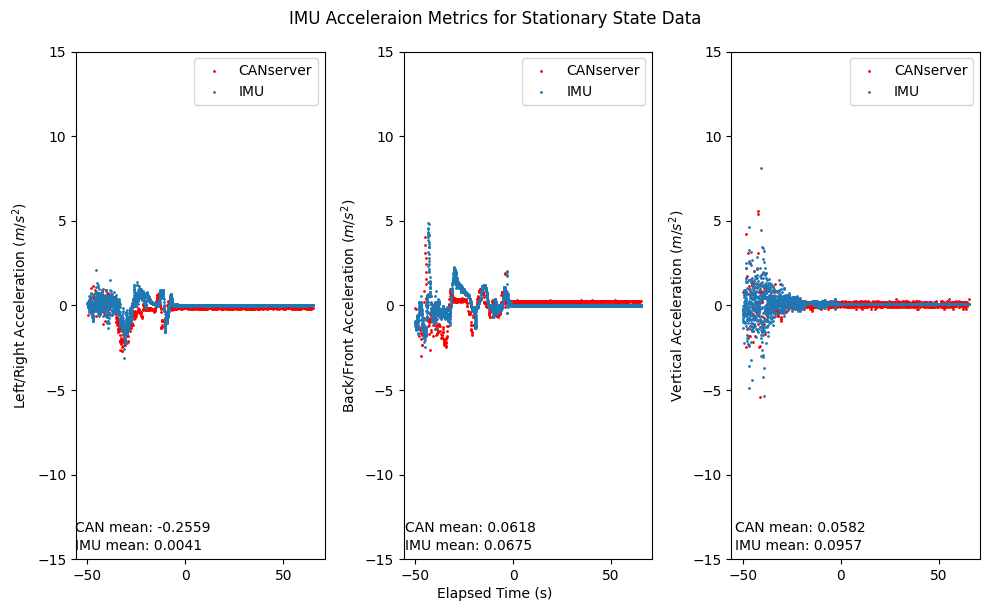

CAN time is 1685551201.24955
IMU raw time is 1685551189.052741
Delta is 12.19680905342102


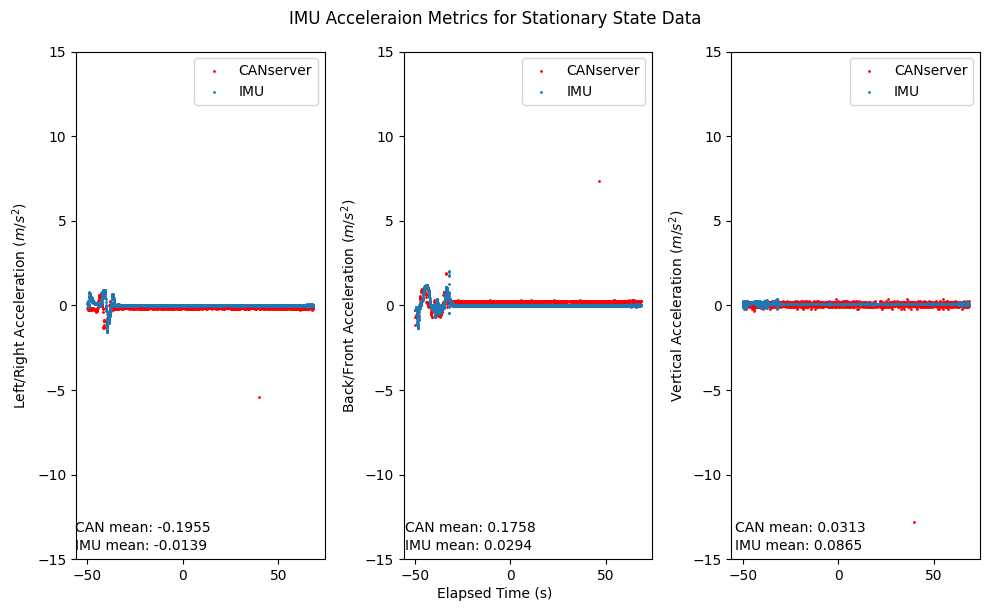

CAN time is 1685551225.90155
IMU raw time is 1685551213.65385
Delta is 12.247699975967407


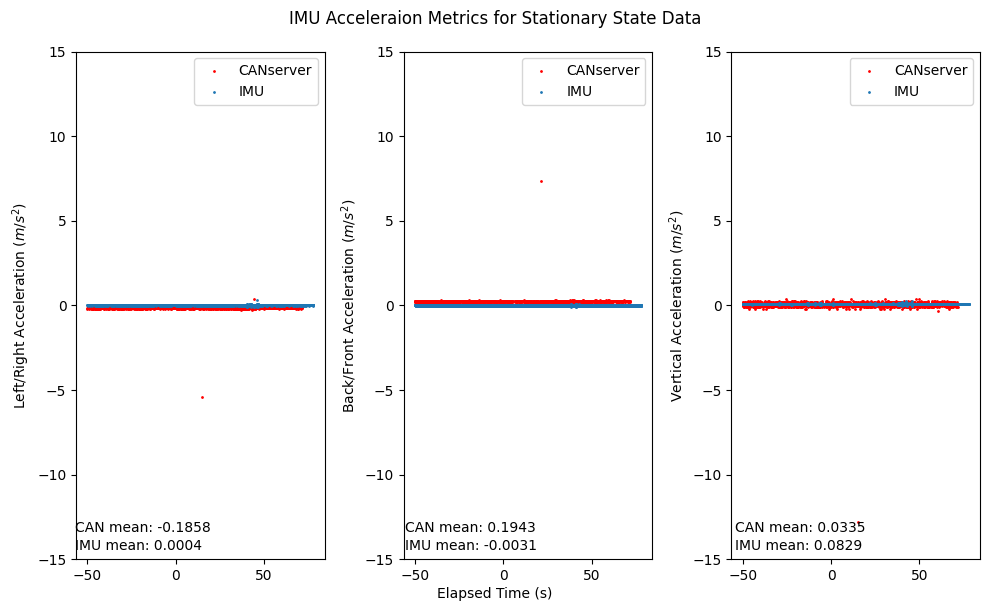

CAN time is 1685580940.48346
IMU raw time is 1685581001.4921315
Delta is -61.0086715221405


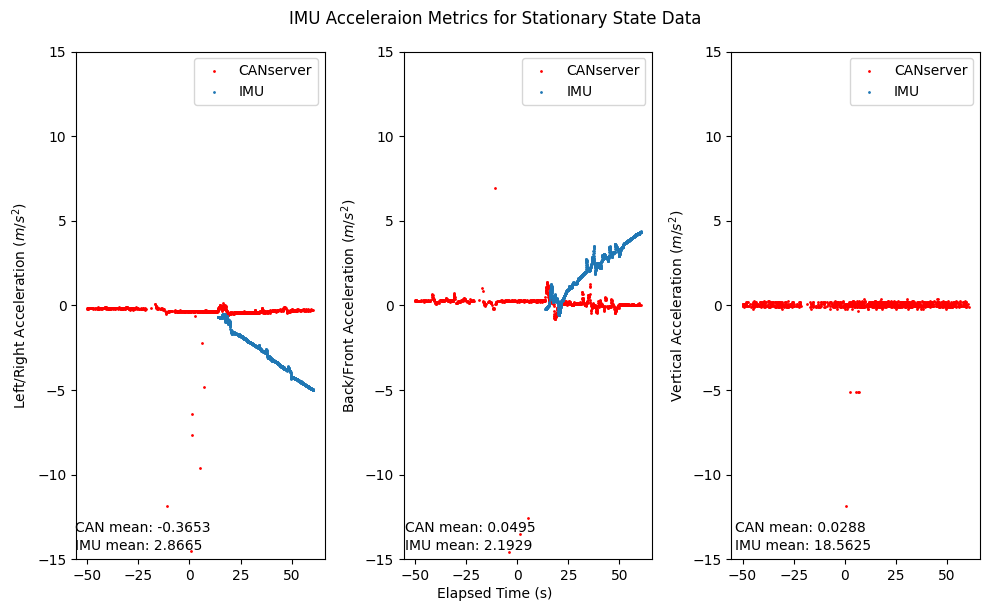

CAN time is 1685581047.255746
IMU raw time is 1685581044.5024602
Delta is 2.7532856464385986


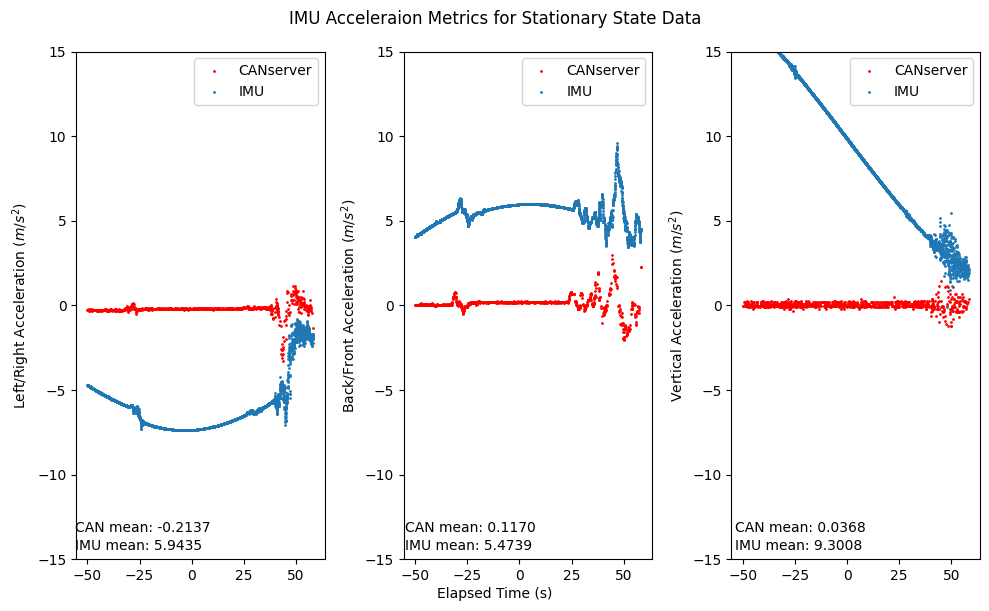

CAN time is 1685581282.097569
IMU raw time is 1685581279.3282015
Delta is 2.7693674564361572


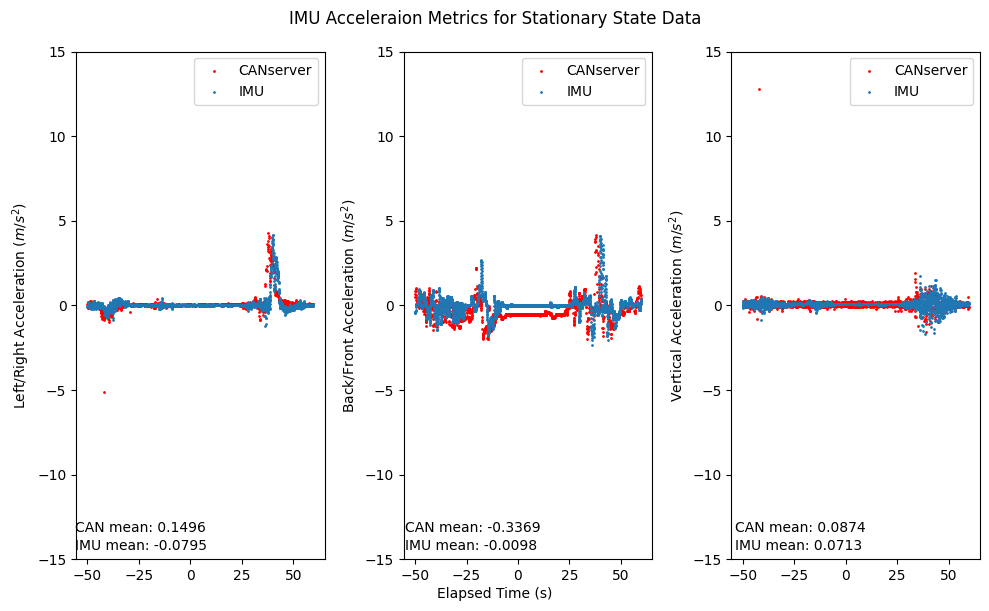

CAN time is 1685582283.137279
IMU raw time is 1685582279.9841352
Delta is 3.153143882751465


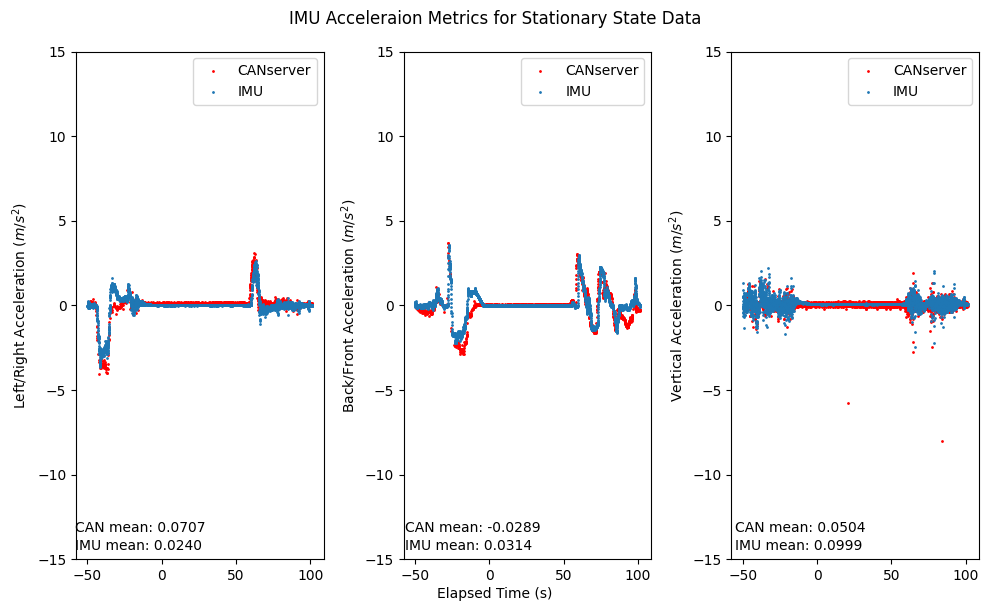

CAN time is 1685582298.237888
IMU raw time is 1685582295.3307
Delta is 2.9071881771087646


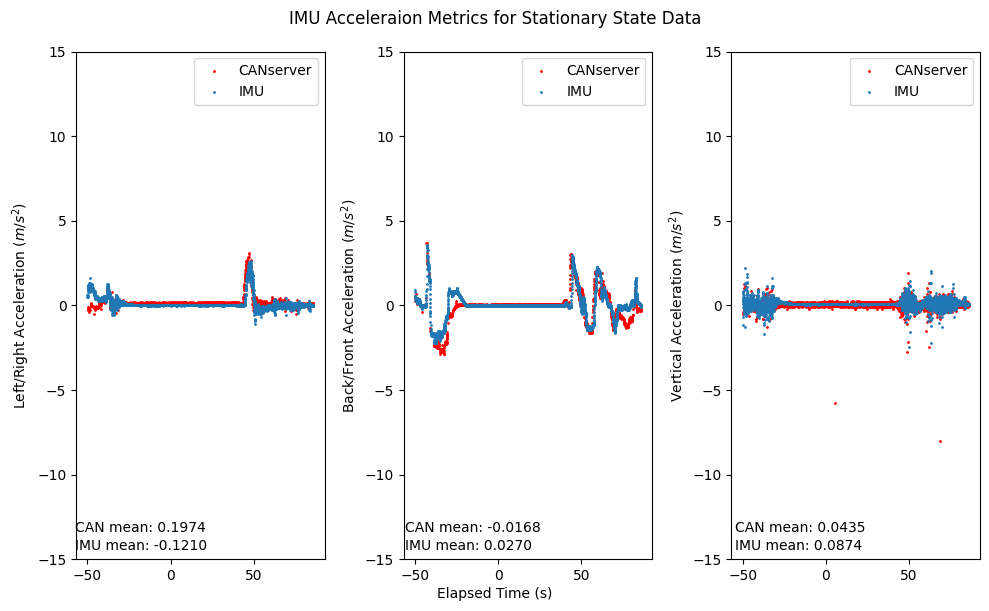

CAN time is 1685582868.169074
IMU raw time is 1685582864.917946
Delta is 3.2511279582977295


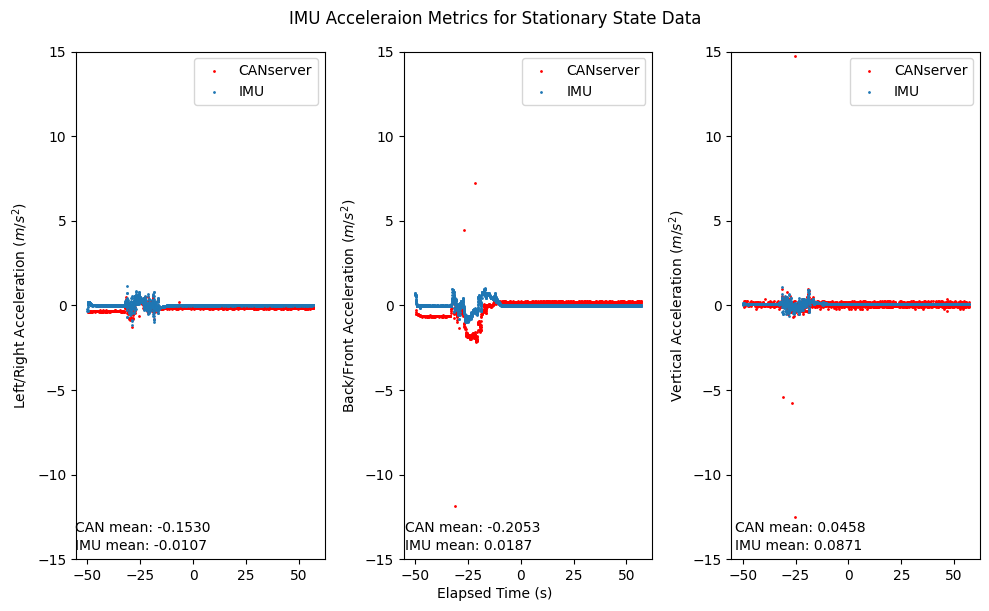

CAN time is 1685582881.289074
IMU raw time is 1685582878.2338371
Delta is 3.05523681640625


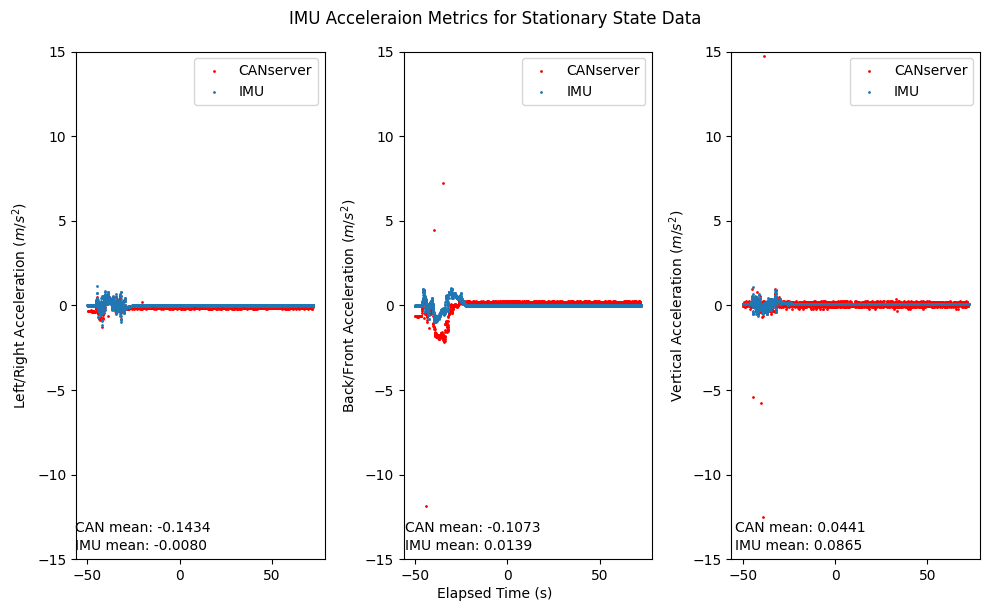

CAN time is 1685582913.588436
IMU raw time is 1685582910.6247427
Delta is 2.963693141937256


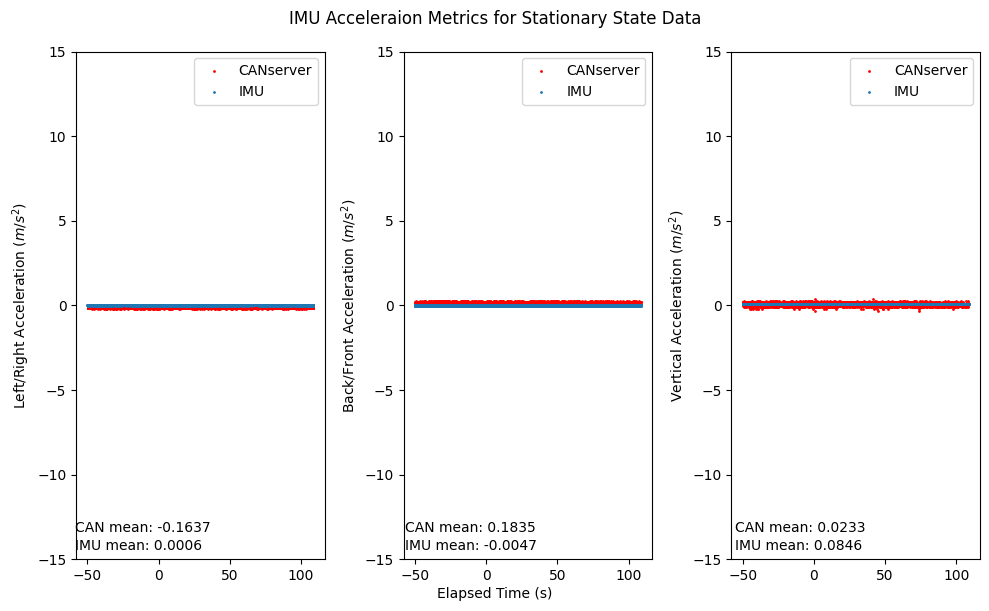

CAN time is 1685582978.744119
IMU raw time is 1685582975.80603
Delta is 2.938088893890381


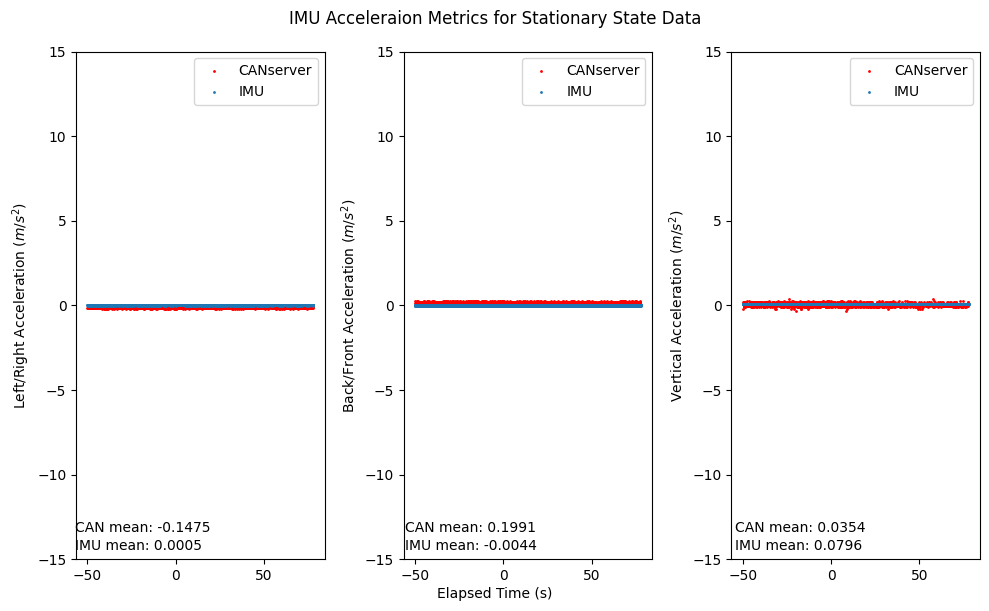

CAN time is 1685583027.815645
IMU raw time is 1685583024.9083788
Delta is 2.907266139984131


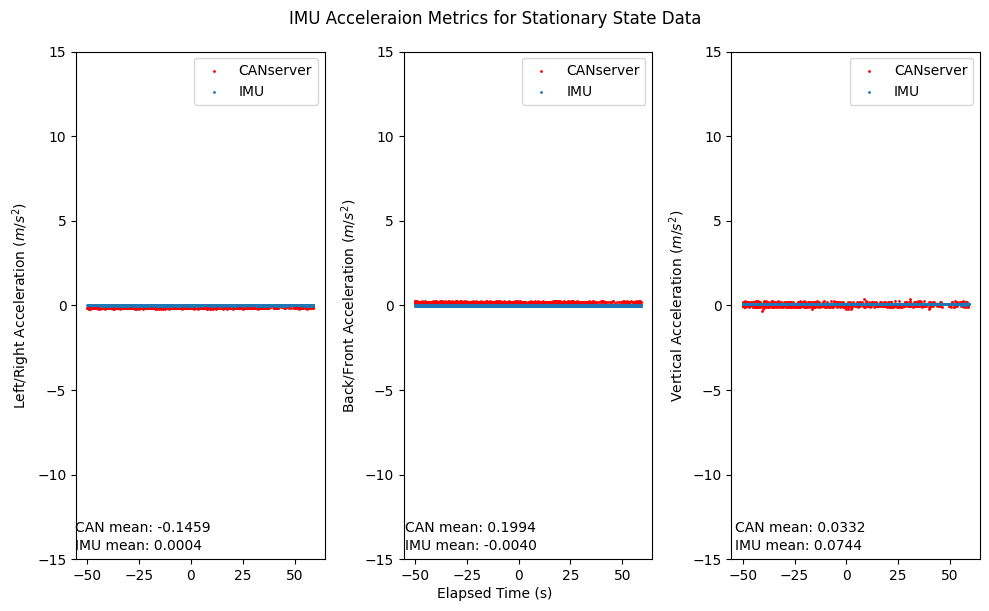

CAN time is 1685583048.474645
IMU raw time is 1685583045.5480103
Delta is 2.9266345500946045


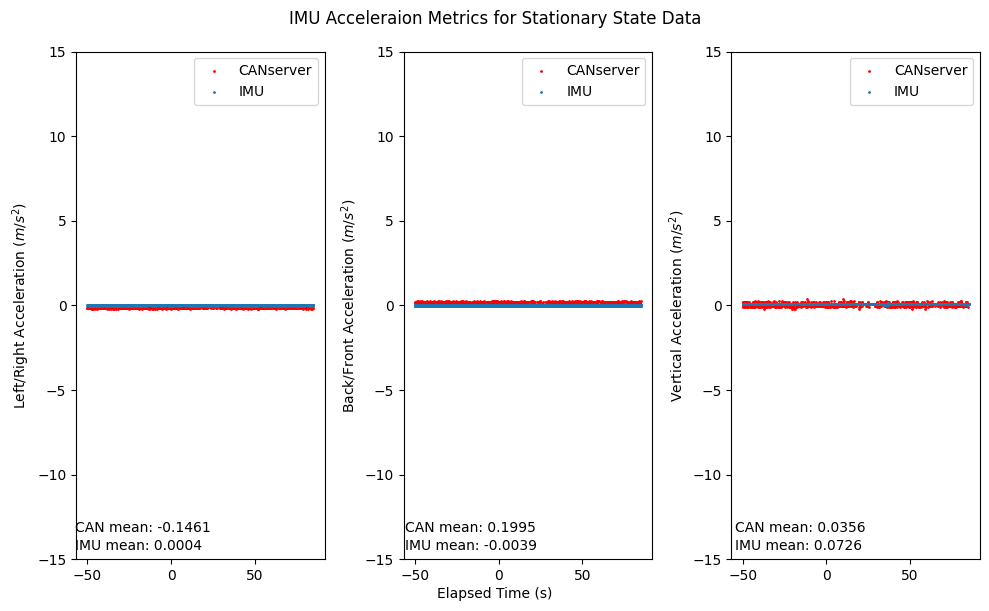

CAN time is 1685583089.856021
IMU raw time is 1685583086.7939832
Delta is 3.062037706375122


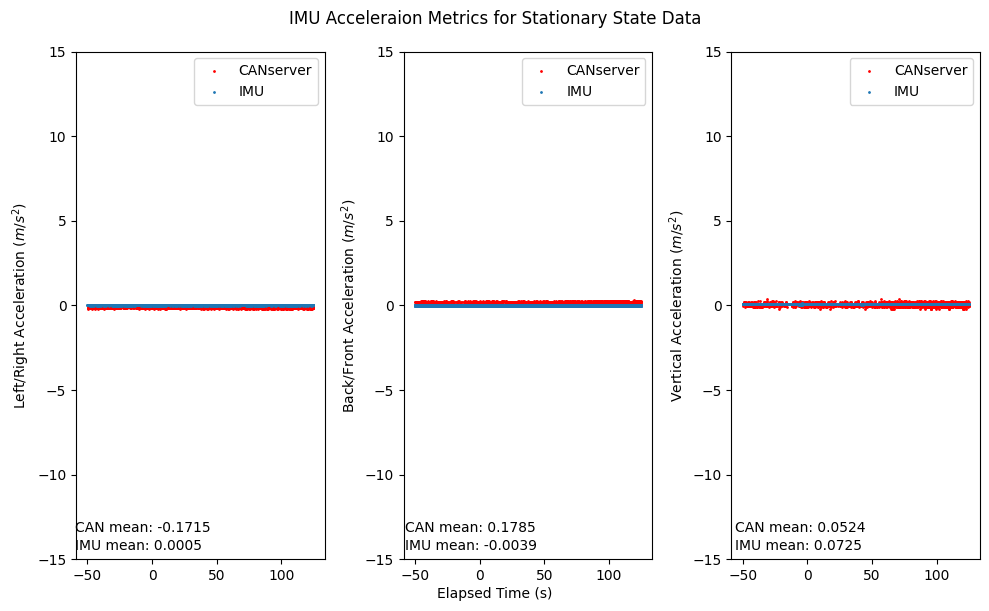

CAN time is 1685583171.845751
IMU raw time is 1685583168.7865832
Delta is 3.0591678619384766


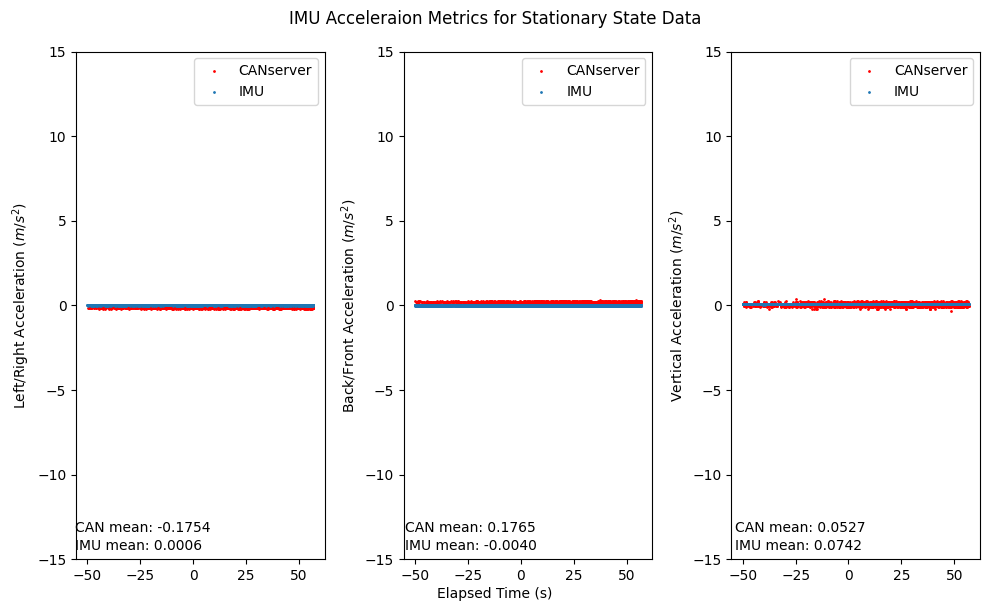

CAN time is 1685583184.864751
IMU raw time is 1685583181.7029977
Delta is 3.1617534160614014


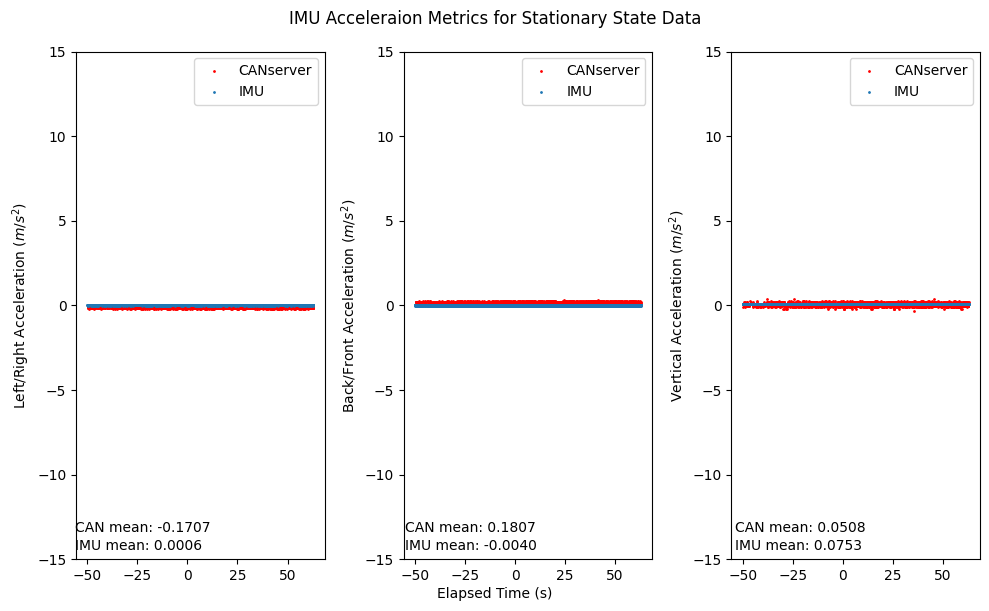

CAN time is 1685583209.76455
IMU raw time is 1685583206.770163
Delta is 2.994386911392212


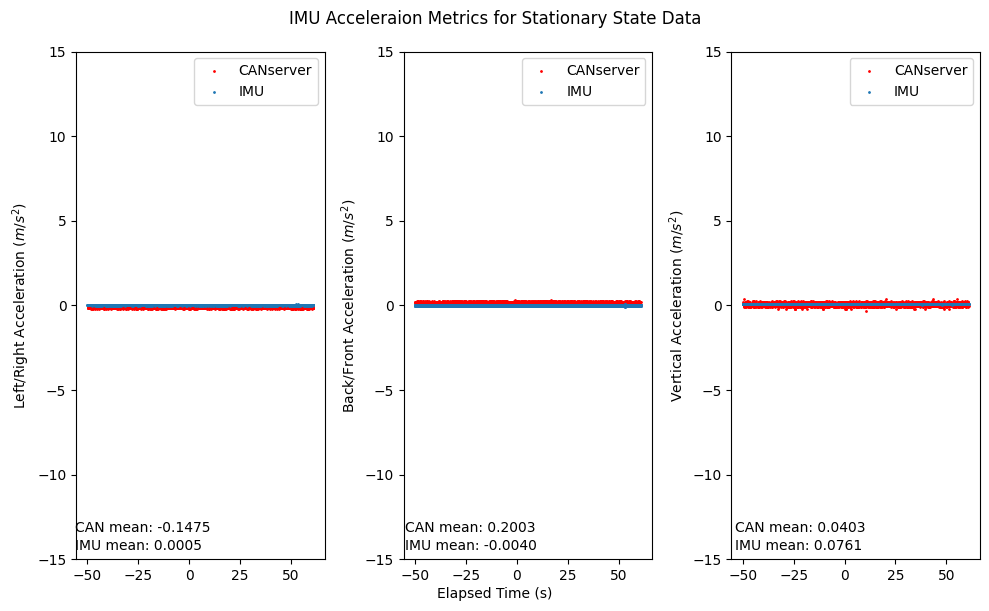

CAN time is 1685583242.594014
IMU raw time is 1685583239.6604142
Delta is 2.9335997104644775


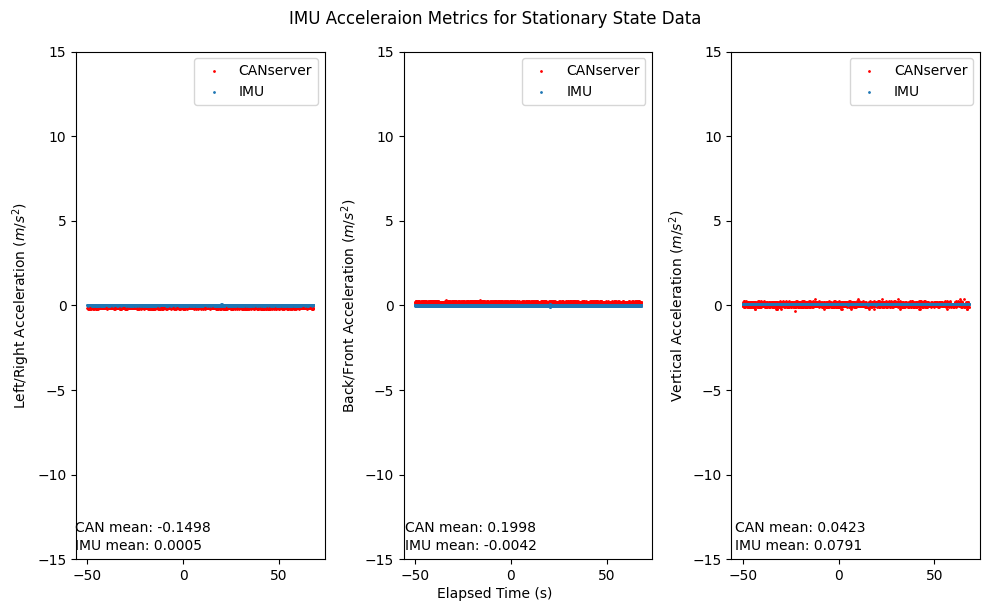

CAN time is 1685583278.893072
IMU raw time is 1685583275.9795074
Delta is 2.913564443588257


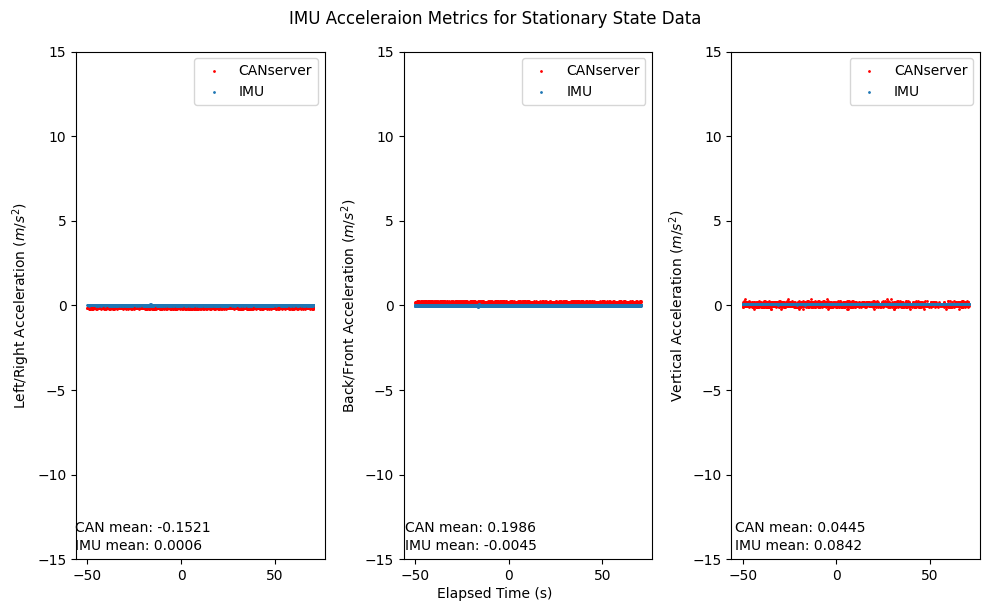

CAN time is 1685583318.613744
IMU raw time is 1685583315.6608632
Delta is 2.952880859375


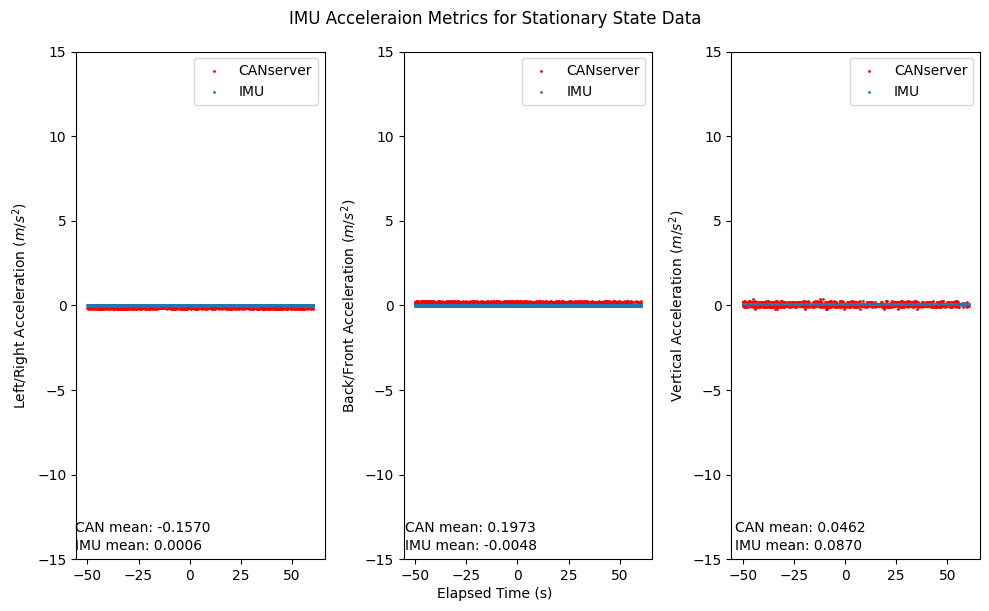

CAN time is 1685583348.434024
IMU raw time is 1685583345.4551697
Delta is 2.9788544178009033


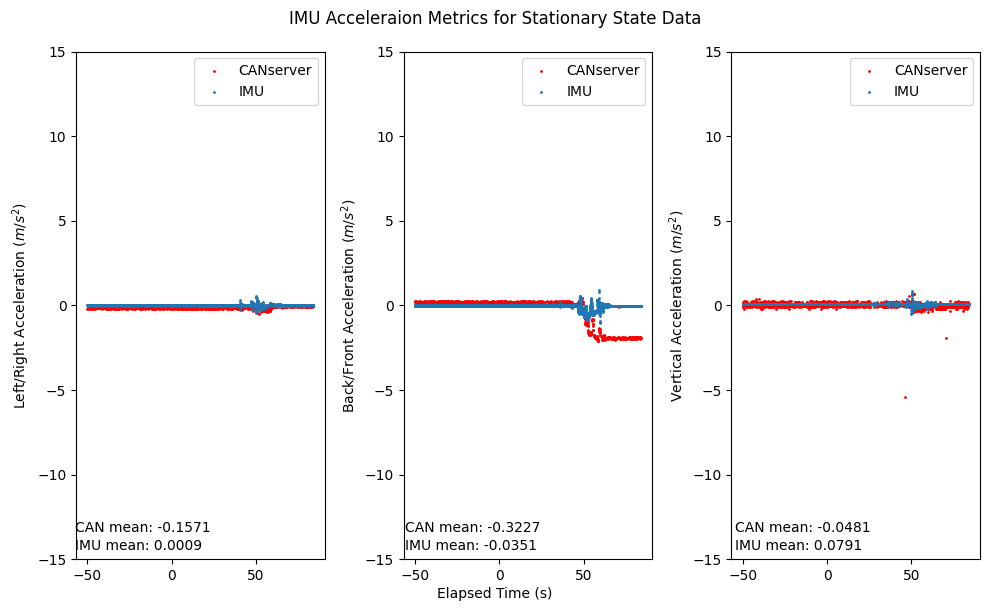

CAN time is 1685583997.721493
IMU raw time is 1685583991.1094444
Delta is 6.612048625946045


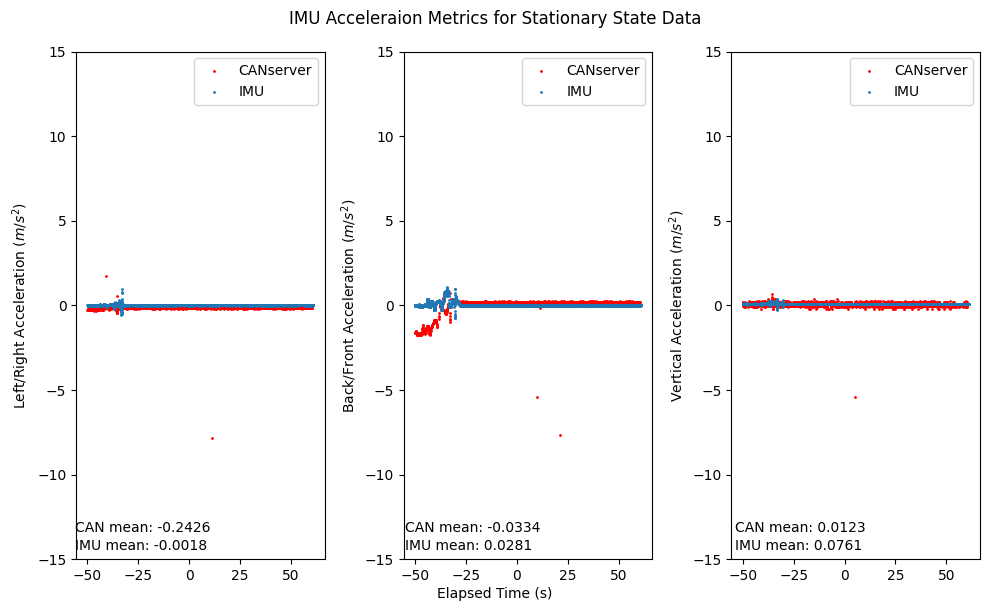

CAN time is 1685584014.801152
IMU raw time is 1685584008.120495
Delta is 6.680656909942627


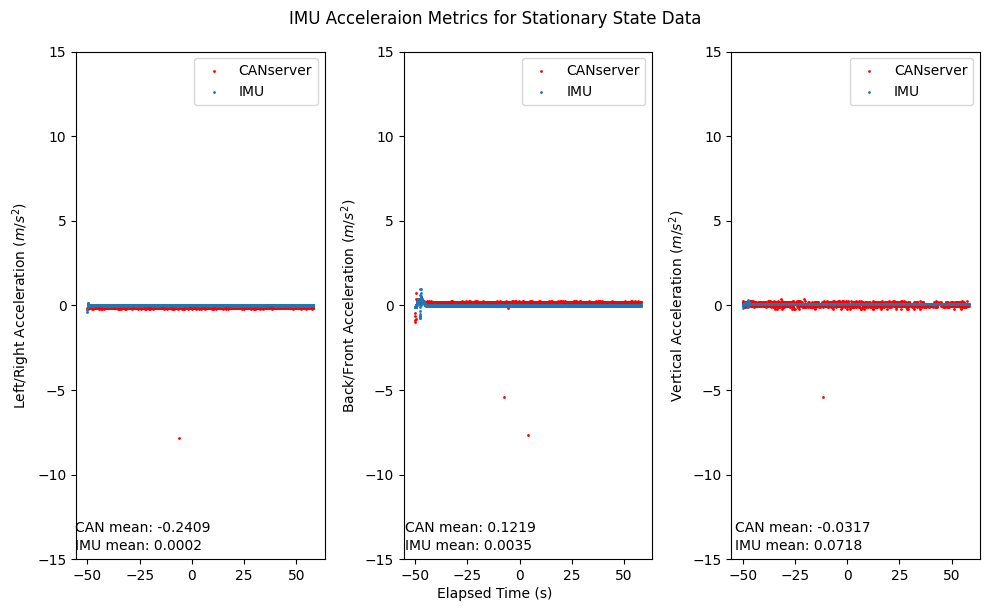

CAN time is 1685584029.200152
IMU raw time is 1685584022.5349476
Delta is 6.665204286575317


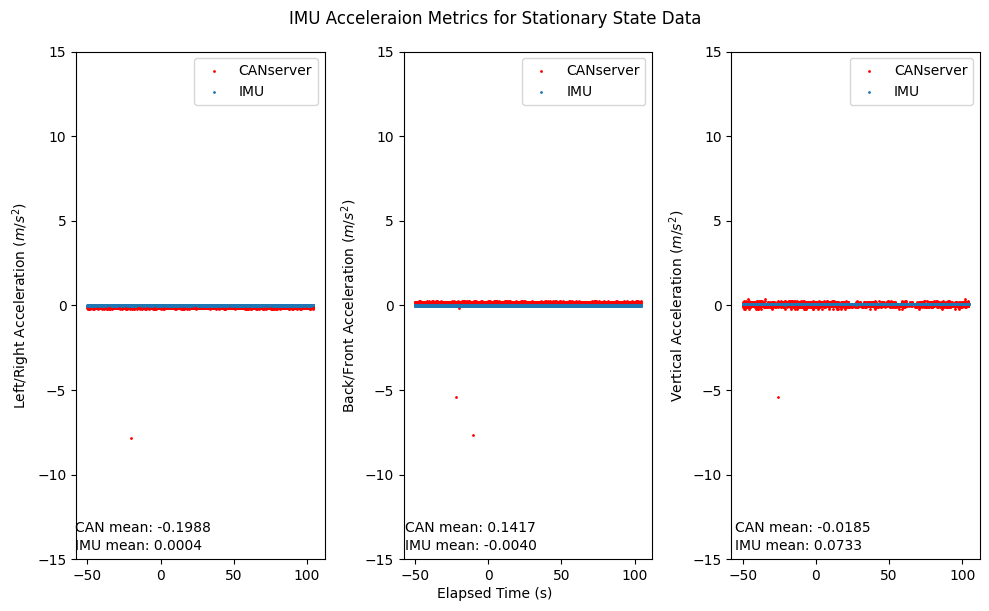

CAN time is 1685584107.371558
IMU raw time is 1685584100.4662008
Delta is 6.905357122421265


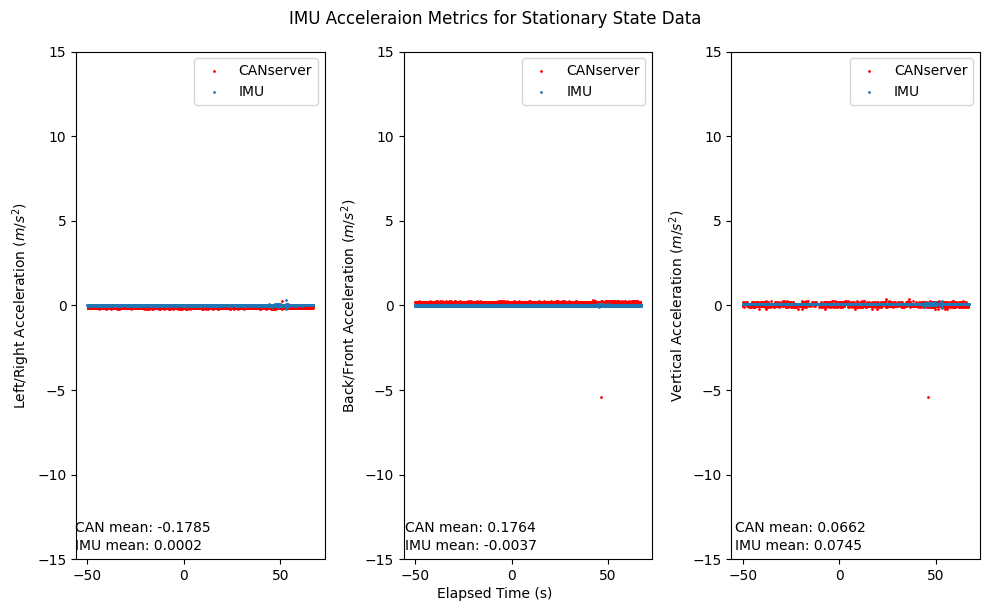

CAN time is 1685584139.991651
IMU raw time is 1685584133.0568445
Delta is 6.93480658531189


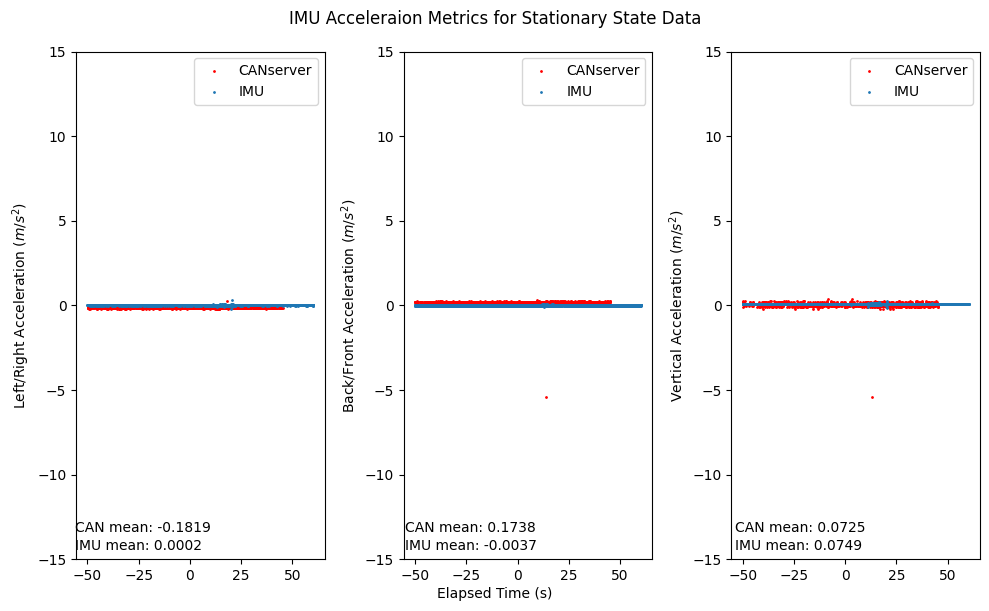

CAN time is 1685632735.203714
IMU raw time is 1685632679.994894
Delta is 55.20881986618042


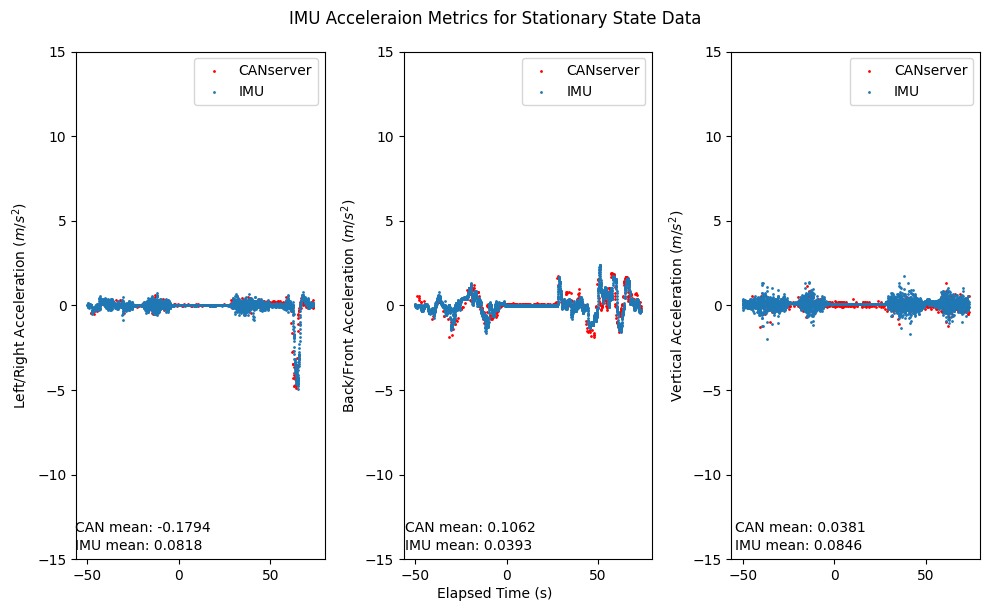

CAN time is 1685633569.035528
IMU raw time is 1685633513.3366551
Delta is 55.698872804641724


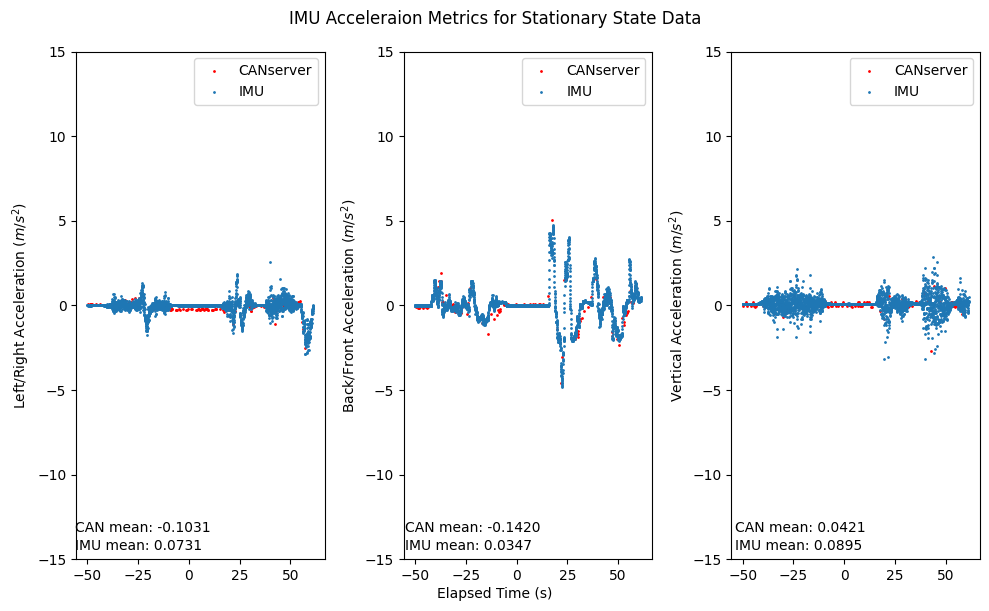

In [27]:
# plotting the IMU stationary state accelerations
edge_time = 50

for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    ss_motion = raw_df[(raw_df['correct_timestamp'] >= ss_start_time - edge_time) 
                       & (raw_df['correct_timestamp'] <= ss_end_time + edge_time)]
    can_motion = can_df[(can_df['timestamp'] >= ss_start_time - edge_time) 
                        & (can_df['timestamp'] <= ss_end_time + edge_time)]

    if (len(ss_motion) != 0):
        print(f'CAN time is {can_motion["timestamp"].iloc[0]}')
        print(f'IMU raw time is {ss_motion["timestamp(epoch in sec)"].iloc[0]}')
        print(f'Delta is {can_motion["timestamp"].iloc[0] - ss_motion["timestamp(epoch in sec)"].iloc[0]}')
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        fig.set_size_inches(10,6)

        lr_mean = ss_motion['lr_acc(m/s^2)'].mean()
        bf_mean = ss_motion['bf_acc(m/s^2)'].mean()
        vert_mean = ss_motion['vert_acc(m/s^2)'].mean()
        lr_can_mean = can_motion['lr_acc'].mean()
        bf_can_mean = can_motion['bf_acc'].mean()
        vert_can_mean = can_motion['vert_acc'].mean()

        ax1.scatter(x=can_motion['timestamp'] - ss_start_time, y=can_motion['lr_acc'], s=1, color='red', label='CANserver')
        ax1.scatter(x=ss_motion['correct_timestamp'] - ss_start_time, y=-ss_motion['lr_acc(m/s^2)'], s=1, label='IMU')
        ax1.set_ylim(-15,15)

        ax2.scatter(x=can_motion['timestamp'] - ss_start_time, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
        ax2.scatter(x=ss_motion['correct_timestamp'] - ss_start_time, y=ss_motion['bf_acc(m/s^2)'], s=1, label='IMU')
        ax2.set_ylim(-15,15)

        ax3.scatter(x=can_motion['timestamp'] - ss_start_time, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
        ax3.scatter(x=ss_motion['correct_timestamp'] - ss_start_time, y=ss_motion['vert_acc(m/s^2)'], s=1, label='IMU')
        ax3.set_ylim(-15,15)

        fig.suptitle("IMU Acceleraion Metrics for Stationary State Data")
        fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

        fig.text(0.08,0.08,f'IMU mean: {lr_mean:.4f}')
        fig.text(0.41,0.08,f'IMU mean: {bf_mean:.4f}')
        fig.text(0.74,0.08,f'IMU mean: {vert_mean:.4f}')
        fig.text(0.08,0.11,f'CAN mean: {lr_can_mean:.4f}')
        fig.text(0.41,0.11,f'CAN mean: {bf_can_mean:.4f}')
        fig.text(0.74,0.11,f'CAN mean: {vert_can_mean:.4f}')

        ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
        ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
        ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.tight_layout()
        plt.show()

Data Plotting for Verification

1


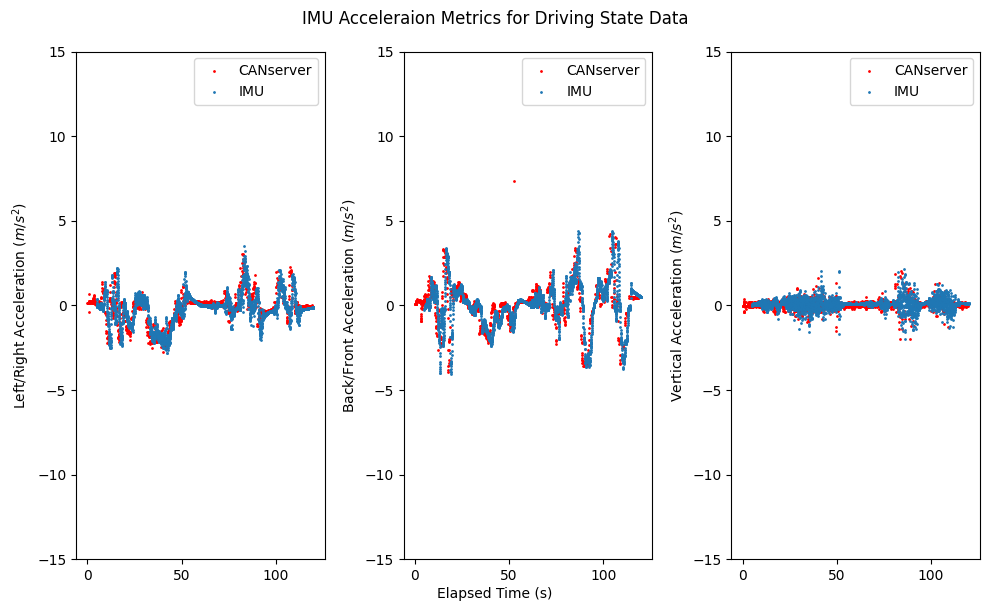

2


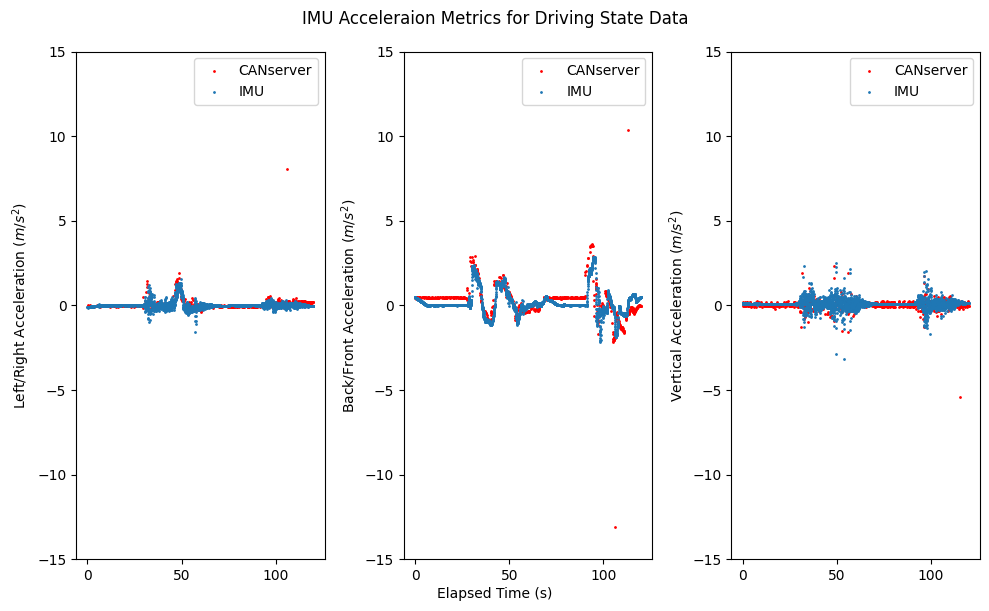

3


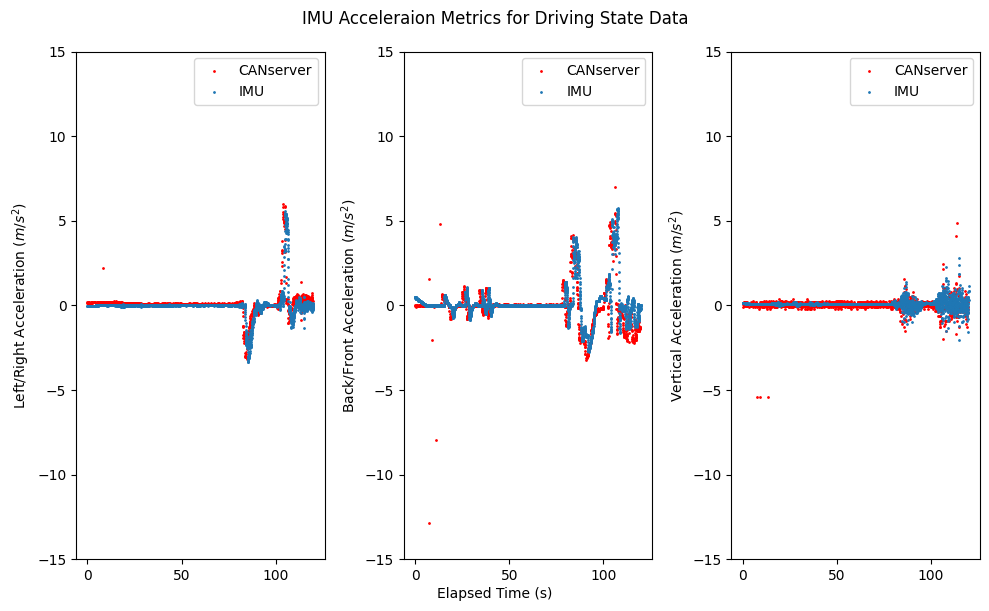

4


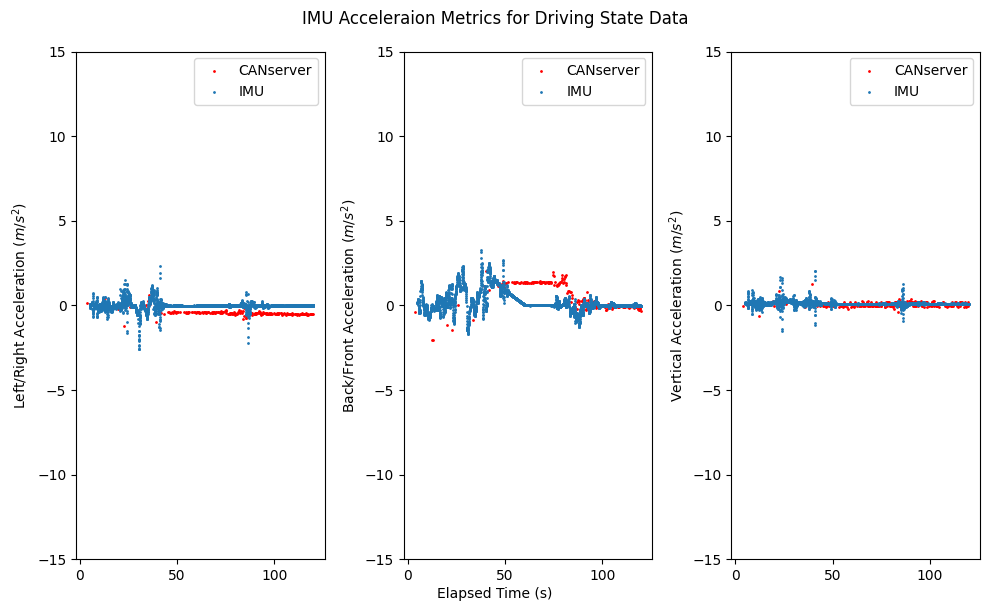

5


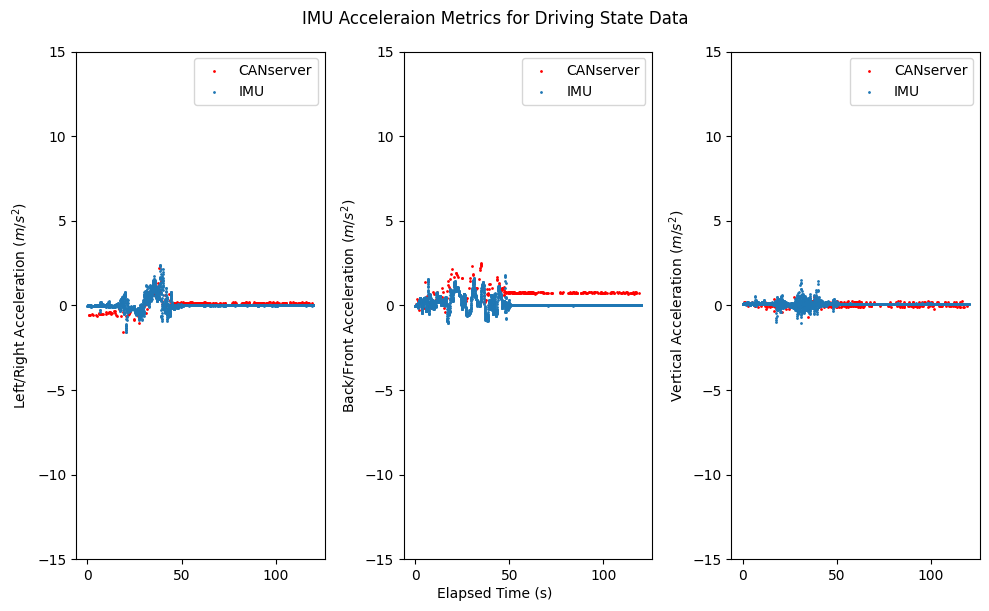

6


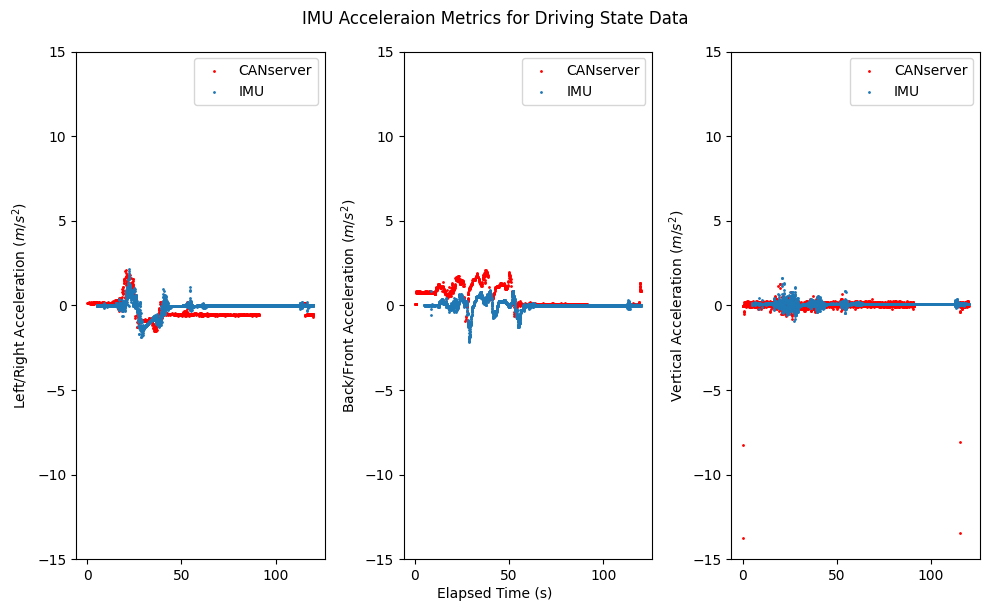

7


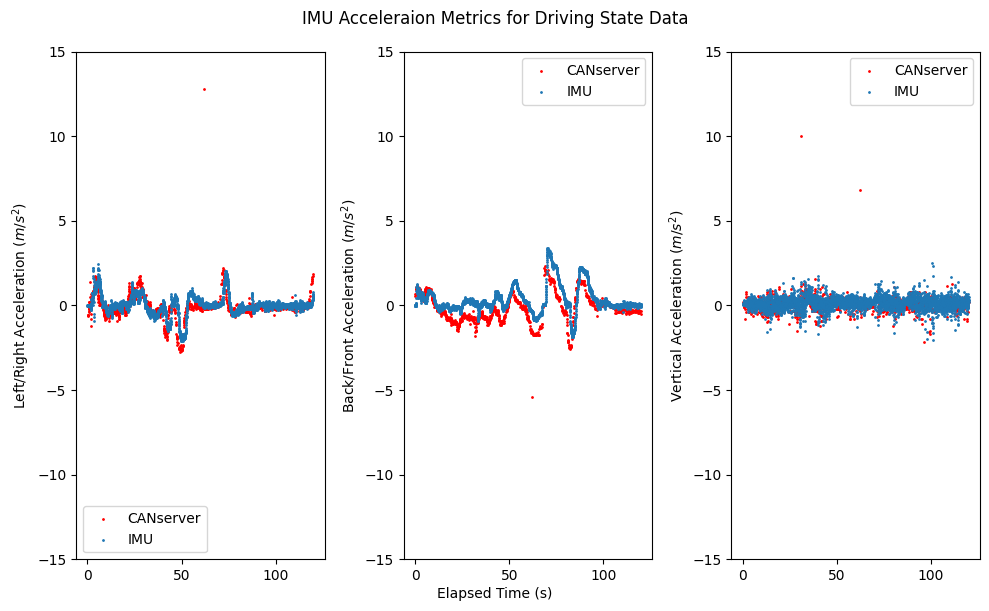

8


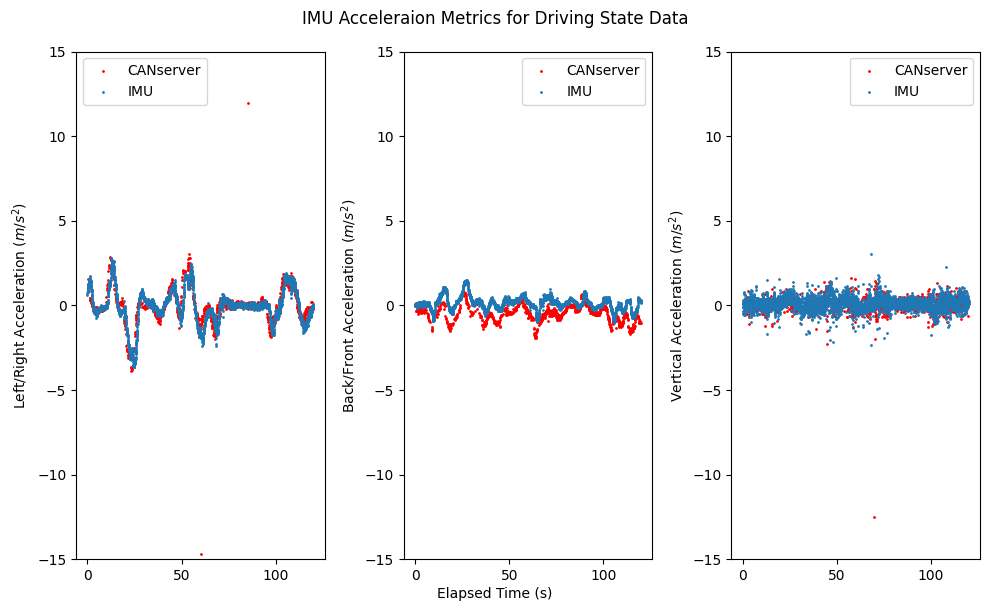

9


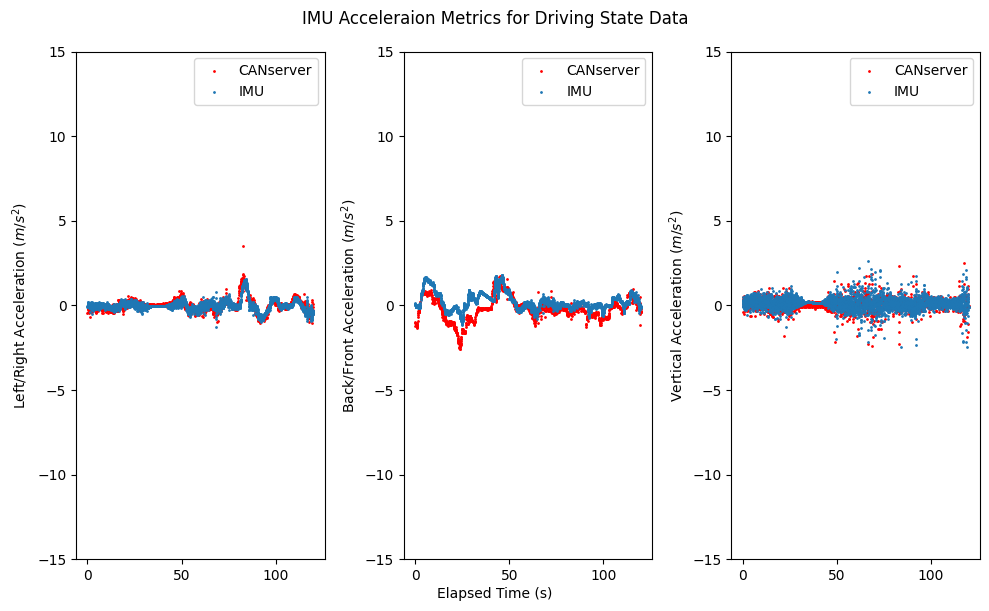

10


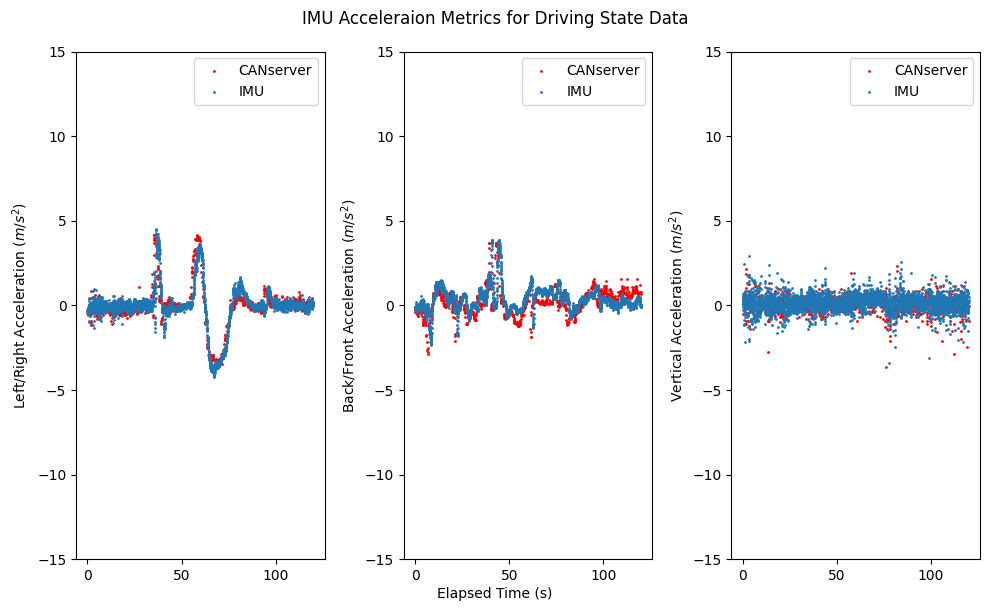

In [89]:
# plot driving state data in intervals of 120 seconds

window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = raw_df[(raw_df['correct_timestamp'] >= dr_start_time) 
                        & (raw_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
            count += 1
            print(count)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            lr_mean = dr_motion['lr_acc(m/s^2)'].mean()
            bf_mean = dr_motion['bf_acc(m/s^2)'].mean()
            vert_mean = dr_motion['vert_acc(m/s^2)'].mean()
            lr_can_mean = can_motion['lr_acc'].mean()
            bf_can_mean = can_motion['bf_acc'].mean()
            vert_can_mean = can_motion['vert_acc'].mean()

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()